# imports 

In [2]:
import os
import pandas as pd
import numpy as np
from scipy.signal import hilbert, convolve
import matplotlib.pyplot as plt
import json

def load_sync_file(mouse_org_data_path,mouse):
    current_animals_behav_sync_path = os.path.join(mouse_org_data_path, r"behav_sync\\")
    for stage in os.listdir(current_animals_behav_sync_path):
        if 'post' in stage:
            sync_path = current_animals_behav_sync_path + stage + '\\'
    if mouse == '148_2_2':
        sync_df = pd.read_csv(sync_path + r'Postsleep_Ephys_Camera_sync.csv', encoding='cp1252')
    else:
        sync_df = pd.read_csv(sync_path + r'Postsleep_Ephys_Camera_sync.csv')
        
    return sync_df 

def load_in_sleep_state_scoring(mouse):
    print('---------------------')
    print('searching for sleep state scoring')
    # determine organised data paths for the current mouse
    if mouse.split('_')[0].isdigit():
        org_dat_path = r"Z:\projects\sequence_squad\organised_data\animals\\"
        old_data = True
    else:
        org_dat_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
        old_data = False
    org_mouse_file = None
    for file in os.listdir(org_dat_path):
        if mouse.split('_')[0] in file:
            # if the implant = implant
            if mouse.split('_')[1] == file.split('_')[-1][-1]:
                print(f'1. mouse file found: \033[1m{file}\033[0m')
                org_mouse_file = os.path.join(org_dat_path,file)
    mouse_org_data_path = None
    for recording in os.listdir(org_mouse_file):
        if mouse.split('_')[-1] == recording.split('_')[0].split('recording')[-1]:
            print(f'2. recording found: \033[1m{recording}\033[0m')
            mouse_org_data_path = os.path.join(org_mouse_file,recording) + r'\\'

    # load in sleep scoring data 
    try:
        sleep_state_score_path = mouse_org_data_path + r"\ephys\ProbeA\LFP\\sleep_state_score\\"
        nrem_start_ends = np.load(sleep_state_score_path + "nrem_start_ends.npy", allow_pickle=True)
        rem_start_ends = np.load(sleep_state_score_path + "rem_start_ends.npy", allow_pickle=True)
        print (f"\033[1mSuccess!\033[0m Loaded sleep state score files for mouse: {mouse}.")
    except:
        print('Fail: not found using first path type...')
    try:
        sleep_state_score_path = mouse_org_data_path + r"\ephys\ProbeA\LFP\\"
        nrem_start_ends = np.load(sleep_state_score_path + "nrem_start_ends.npy", allow_pickle=True)
        rem_start_ends = np.load(sleep_state_score_path + "rem_start_ends.npy", allow_pickle=True)
        print (f"\033[1mSuccess!\033[0m Loaded sleep state score files for mouse: {mouse}.")
    except:
        print(f"Sleep state score files not found for {mouse}.")

    print('----------------------')
        
    return nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data


def filter_for_spindles_and_plot(spindle_bandpassed,nrem_intervals,rem_intervals,fs,min_event_duration,sleep_period_ephys_start_time):

    time = np.arange(len(spindle_bandpassed)) / fs
    # adjust time to account for trimmed down ephys lfp
    time += sleep_period_ephys_start_time

    # Compute the smoothed envelope
    smoothed_envelope = compute_smoothed_envelope(spindle_bandpassed, fs)

    ## filter for NREM sleep times only and find mean and s-dev
    nrem_envelope_perioids = []
    for interval in nrem_intervals:
        nrem_envelope_perioids += list(smoothed_envelope[(time > interval[0]) * (time < interval[1])])
    mean_ = np.mean(nrem_envelope_perioids)
    std_ = np.std(nrem_envelope_perioids)

    upper_threshold = mean_ + 2*std_
    lower_threshold = mean_ + 1*std_

    # Plotting the original signal and the smoothed envelope
    fig, [ax,ax2] = plt.subplots(2, 1,figsize=(20, 10))
    ax.plot(time, spindle_bandpassed, color='b')
    ax.plot(time, smoothed_envelope, label='Smoothed Envelope', color='r')
    ax.axhline(upper_threshold,color = 'c')
    ax.axhline(lower_threshold,color = 'c')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    ax.set_xlim(sleep_period_ephys_start_time+100,sleep_period_ephys_start_time+120)
    ax.set_ylim((-1*upper_threshold)-(0.6*upper_threshold),upper_threshold +(0.6*upper_threshold))

    ## filter for spindles

    offset = sleep_period_ephys_start_time
    spindle_events = find_events(smoothed_envelope,lower_threshold, upper_threshold,fs,min_event_duration,offset)

    ax2.plot(time, spindle_bandpassed, color='b')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Amplitude')

    for event in spindle_events:
        ax2.axvspan(event['start_time'],event['end_time'], alpha=0.5, color='red')
        
    ax2.set_ylim((-1*upper_threshold)-(1.5*upper_threshold),upper_threshold +(1.5*upper_threshold))


    # Add shaded regions without repeating labels
    for ind, (start, end) in enumerate(rem_intervals):
        label = 'rem' if ind == 0 else None
        ax2.axvspan(start, end, color='yellow', alpha=0.2, label=label)

    for ind, (start, end) in enumerate(nrem_intervals):
        label = 'nrem' if ind == 0 else None
        ax2.axvspan(start, end, color='green', alpha=0.2, label=label)

    ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
    
    return spindle_events,smoothed_envelope

def compute_smoothed_envelope(signal, sampling_rate, window_length_ms=200):
    # Convert window length from milliseconds to samples
    window_length_samples = int(window_length_ms * sampling_rate / 1000)
    
    # Compute the analytic signal using Hilbert transform
    analytic_signal = hilbert(signal)
    
    # Compute the magnitude of the analytic signal
    magnitude = np.abs(analytic_signal)
    
    # Create a Gaussian window with specified length
    gaussian_window = np.exp(-0.5 * (np.arange(-window_length_samples, window_length_samples+1) / (0.001 * sampling_rate))**2)
    
    # Normalize the Gaussian window
    gaussian_window /= np.sum(gaussian_window)
    
    # Convolve the magnitude with the Gaussian window
    smoothed_envelope = convolve(magnitude, gaussian_window, mode='same')
    
    return smoothed_envelope

def find_events(signal_data, lower_threshold, upper_threshold, sampling_rate,time_filter,offset):
    events = []
    event_start = None
    peak_magnitude = None
    sum_magnitude = 0
    count_samples = 0

    for i, sample in enumerate(signal_data):
        # Check if the signal crosses the lower threshold
        if sample > lower_threshold:
            if event_start is None:
                event_start = i

            # Check if the signal crosses the upper threshold within the event window
            if sample > upper_threshold:
                peak_magnitude = max(signal_data[event_start:i + 1])
                sum_magnitude += sample
                count_samples += 1

        else:
            # If the event window duration is at least the time filter (s * sampling_rate)
            if event_start is not None and (i - event_start) >= (time_filter * sampling_rate):
                if peak_magnitude is not None and peak_magnitude > upper_threshold:
                    average_magnitude = sum_magnitude / count_samples
                    events.append({
                        "start_time": (event_start / sampling_rate)+offset,
                        "end_time": (i / sampling_rate)+offset,
                        "peak_magnitude": peak_magnitude,
                        'magnitude': sum_magnitude,
                        "average_magnitude": average_magnitude,
                    })

            # Reset event variables
            event_start = None
            peak_magnitude = None
            sum_magnitude = 0
            count_samples = 0

    return events

def load_in_replay_data(mouse,dat_path,nrem_start_ends,rem_start_ends):
    
    print('---------------------')
    print('searching for replay data')

    pp_path = 'SKIP'
    for file in os.listdir(dat_path):
        if mouse == file.split('_run')[0]:
            print(f'file found: \033[1m{file}\033[0m')
            pp_path = os.path.join(dat_path,file)

    if pp_path == 'SKIP':
        return None,'SKIP'
    
    replay_data_path = pp_path + r'\_final_analysis_output\\'

    params_file = pp_path + r'\trainingData\\' + 'params_' + mouse + '.json'
    with open(params_file, 'r') as file:
        params = json.load(file)
    time_spans = params['time_span']

    replay_events_df = pd.DataFrame({})
    start_offset = []
    for file in os.listdir(replay_data_path):
        if 'chunk' in file:
            print(file)

            chunk_number = int(file.split('_')[0][-1])

            start_offs = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
            start_offset +=[start_offs]

            print(replay_data_path)
            df_load = pd.read_csv(replay_data_path + file + r'\filtered_replay_clusters_df.csv',index_col=0)
            
            # ## filter this data for sequential ordering
            # sequential_condition = df_load.ordering_classification == 'sequential'
            # # filter is set up so that any true will carry forward 
            # filtered_chunk_data = df_load[sequential_condition].reset_index()
            # ## REM / NREM times only
            # # get relevant rem/nrem times for chunk
            # chunk_time = np.load(replay_data_path + file + '\chunk_time_interval.npy')
            # chunk_nrem_times = get_chunk_state_times(nrem_start_ends,chunk_time)
            # chunk_rem_times = get_chunk_state_times(rem_start_ends,chunk_time) 
            # # get spike times relative to chunk:
            # chunk_number = int(file.split('_')[0][-1])
            # chunk_start_offset = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
            # # make relative to start of chunk
            # fs_event_times = filtered_chunk_data['first_spike_time'].values - chunk_start_offset
            # # find inds of spike times that are in nrem and rem periods:
            # idx  = []
            # for start,end in chunk_nrem_times + chunk_rem_times:
            #     idx += list(np.where((fs_event_times >= start) & (fs_event_times <= end))[0])
            # filter the data frame, only keeping the rows in idx
            
            filtered_chunk_data = df_load
            # filtered_chunk_data = filtered_chunk_data.iloc[idx]
            filtered_chunk_data = filtered_chunk_data.reset_index(drop=True)
            

            filtered_chunk_data['chunk'] = [chunk_number]*len(filtered_chunk_data)
            
            filtered_chunk_data['chunk_time'] = [time_spans[chunk_number-1]]*len(filtered_chunk_data)
            fs_times_ephys_time = (filtered_chunk_data.first_spike_time.values - start_offs)
            filtered_chunk_data['first_spike_ephys_time'] = fs_times_ephys_time
            filtered_chunk_data["replay_abs_time"] = filtered_chunk_data['chunk_time'].values[0][0] + filtered_chunk_data["first_spike_ephys_time"] + filtered_chunk_data["event_length"]/2
            
            replay_events_df = pd.concat((replay_events_df,filtered_chunk_data),axis =0)
            replay_events_df.reset_index(drop = True)
            
            print (f"\033[1mSuccess!\033[0m Loaded replay data files for mouse: {mouse}.")
            print('---------------------')
                
    return replay_events_df,time_spans



def get_chunk_state_times(rem_start_ends,chunk_time):
    chunk_rem_times = []
    for start,end in rem_start_ends:
        if start >= chunk_time[0] and start <= chunk_time[1]:
            start_chunk_rebased = start - chunk_time[0]
            end_chunk_rebased = end - chunk_time[0]
            # expand by 10%
            start_chunk_rebased = start_chunk_rebased * 0.9
            end_chunk_rebased = end_chunk_rebased * 1.1
            # if the end stetches past the end of the chunk then just set it to the end of the chunk
            if end_chunk_rebased > np.diff(chunk_time)[0]:
                end_chunk_rebased = np.diff(chunk_time)[0]
            chunk_rem_times += [[start_chunk_rebased,end_chunk_rebased]]
    return chunk_rem_times


from scipy.stats import zscore

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def phase_randomize(signal):
    n = len(signal)
    # FFT
    fft_vals = np.fft.fft(signal)

    # Preserve magnitude
    mag = np.abs(fft_vals)

    # Random phase, symmetric to ensure real inverse
    random_phases = np.exp(1j * np.random.uniform(0, 2*np.pi, n//2 - 1))
    phase = np.ones(n, dtype=complex)
    phase[1:n//2] = random_phases
    phase[-(n//2)+1:] = np.conj(random_phases[::-1])  # Hermitian symmetry

    # New FFT
    new_fft = mag * phase

    # Inverse FFT
    randomized_signal = np.fft.ifft(new_fft).real
    return randomized_signal

import numpy as np
import matplotlib.pyplot as plt

def calculate_cross_correlation(
        replay_aligned_spndl_spectral_powers,
        spndl_replay_binned,
        smoothing_window,
        bin_duration_seconds,
        num_shuffles=5000,
         # <-- set this to the time per bin (seconds) e.g. 20 ms bins -> 0.02
    ):
    chunk_cross_corr_actual = []
    chunk_temporal_shuffle = []
    chunk_phase_shuffle = []
    chunk_time_lags_samples = []   # store sample-lag axis for each chunk
    chunk_time_lags_seconds = []   # store time axis (seconds)
    
    for idx in range(len(spndl_replay_binned)):
        signal1 = zscore(convolve_movmean(replay_aligned_spndl_spectral_powers[idx], smoothing_window))
        signal2 = zscore(convolve_movmean(spndl_replay_binned[idx], smoothing_window))
        N = len(signal1)
        # cross-correlation (length = 2*N - 1)
        cross_corr_actual = np.correlate(signal1, signal2, mode='full')

        # lags in samples: -(N-1), ..., 0, ..., +(N-1)
        lags_samples = np.arange(-(N-1), N)

        # shuffles (avoid reusing idx as loop var)
        temporal_shuffle = []
        phase_shuffle = []
        for s in range(num_shuffles):
            t_shuffled_signal1 = np.random.permutation(signal1)
            p_shuffled_signal1 = phase_randomize(signal1)
            temporal_shuffle.append(np.correlate(t_shuffled_signal1, signal2, mode='full'))
            phase_shuffle.append(np.correlate(p_shuffled_signal1, signal2, mode='full'))

        percntl_99_temporal = np.percentile(temporal_shuffle, 95, axis=0)
        percntl_99_phase = np.percentile(phase_shuffle, 95, axis=0)

        # if you want to restrict to +/-40 samples around 0:
        # NOTE: 100 here means 100 *bins/samples*, not seconds.
        mask = (lags_samples >= -100) & (lags_samples <= 100)

        chunk_cross_corr_actual.append(cross_corr_actual[mask].tolist())
        chunk_temporal_shuffle.append(percntl_99_temporal[mask].tolist())
        chunk_phase_shuffle.append(percntl_99_phase[mask].tolist())

        # store lag axes
        chunk_time_lags_samples.append(lags_samples[mask].tolist())
        chunk_time_lags_seconds.append((lags_samples[mask] * bin_duration_seconds).tolist())

    # return also time axes so you can plot x properly
    return (chunk_cross_corr_actual,
            chunk_temporal_shuffle,
            chunk_phase_shuffle,
            chunk_time_lags_samples,
            chunk_time_lags_seconds)


# main

seq006_1_1
ripples found
---------------------
searching for sleep state scoring
1. mouse file found: seq006_implant1
2. recording found: recording1_15-11-2024
Fail: not found using first path type...
Success! Loaded sleep state score files for mouse: seq006_1_1.
----------------------
spindle events not found - processing...
---------------------
searching for replay data
file found: seq006_1_1_run_0907025_1800
chunk1_11300to13600
Z:\projects\sequence_squad\ppseq_finalised_publication_data\dual_str_hpc\striatum\postsleep\\seq006_1_1_run_0907025_1800\_final_analysis_output\\
Success! Loaded replay data files for mouse: seq006_1_1.
---------------------
av ripple rate: 6.47 per minute
Lowest ripple rate: 0.00 per minute
Highest ripple rate: 32.00 per minute
----------------------------------------------------------
seq006_1_3
ripples found
---------------------
searching for sleep state scoring
1. mouse file found: seq006_implant1
2. recording found: recording3_18-11-2024
Fail: not foun

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_26356\1788989695.py:145: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4,4))


----------------------------------------------------------
seq006_1_6
ripples found
---------------------
searching for sleep state scoring
1. mouse file found: seq006_implant1
2. recording found: recording6_21-11-2024
Fail: not found using first path type...
Success! Loaded sleep state score files for mouse: seq006_1_6.
----------------------
spindle events not found - processing...
---------------------
searching for replay data
file found: seq006_1_6_run_2905025_0946
chunk1_11900to13600
Z:\projects\sequence_squad\ppseq_finalised_publication_data\dual_str_hpc\striatum\postsleep\\seq006_1_6_run_2905025_0946\_final_analysis_output\\
Success! Loaded replay data files for mouse: seq006_1_6.
---------------------
chunk2_14000to15400
Z:\projects\sequence_squad\ppseq_finalised_publication_data\dual_str_hpc\striatum\postsleep\\seq006_1_6_run_2905025_0946\_final_analysis_output\\
Success! Loaded replay data files for mouse: seq006_1_6.
---------------------
av ripple rate: 11.79 per minute
Lo

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_26356\1788989695.py:257: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(full_out_path + '/linkage_lags_actual_vs_shuffle.png')


----------------------------------------------------------
seq007_1_2
ripples found
---------------------
searching for sleep state scoring
1. mouse file found: seq007_implant1
2. recording found: recording2_19-11-2024
Fail: not found using first path type...
Success! Loaded sleep state score files for mouse: seq007_1_2.
----------------------
spindle events not found - processing...
---------------------
searching for replay data
file found: seq007_1_2_run_2905025_0509
chunk1_10900to11900
Z:\projects\sequence_squad\ppseq_finalised_publication_data\dual_str_hpc\striatum\postsleep\\seq007_1_2_run_2905025_0509\_final_analysis_output\\
Success! Loaded replay data files for mouse: seq007_1_2.
---------------------
chunk2_12200to13400
Z:\projects\sequence_squad\ppseq_finalised_publication_data\dual_str_hpc\striatum\postsleep\\seq007_1_2_run_2905025_0509\_final_analysis_output\\
Success! Loaded replay data files for mouse: seq007_1_2.
---------------------
chunk3_14500to15500
Z:\projects\seq

FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\projects\\sequence_squad\\revision_data\\emmett_revisions\\oscillations\\striatum_lfp\\dual_hpc_str\\\\seq008_1_3\\processed_data\\zscored_spindle_bandpassed.npy'

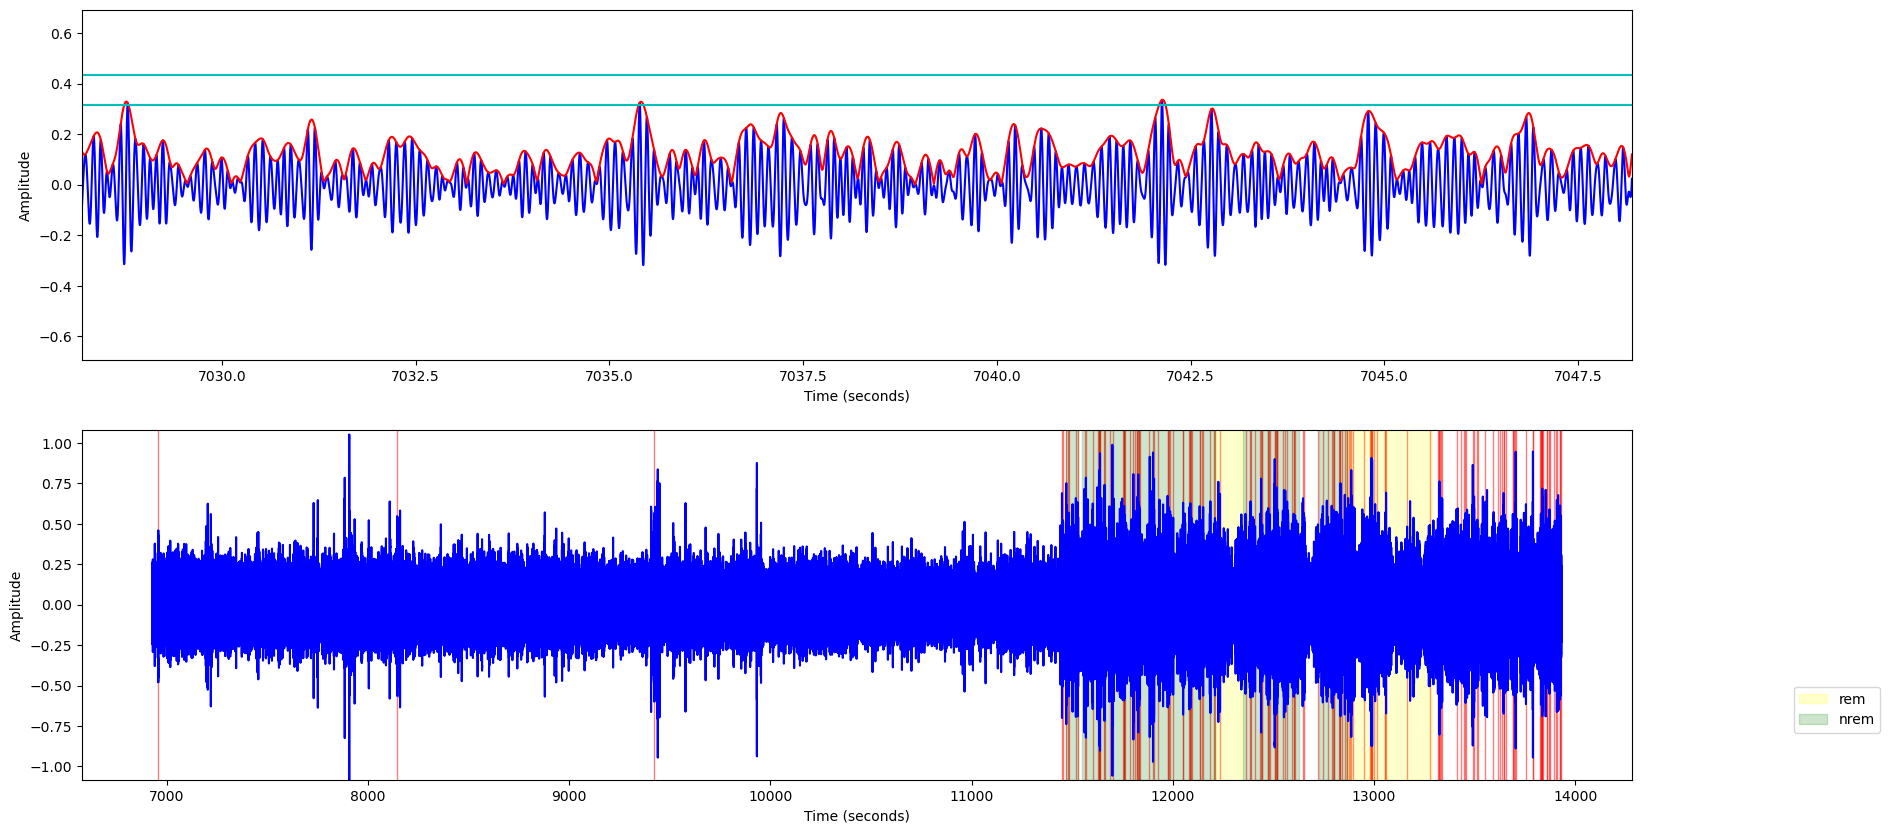

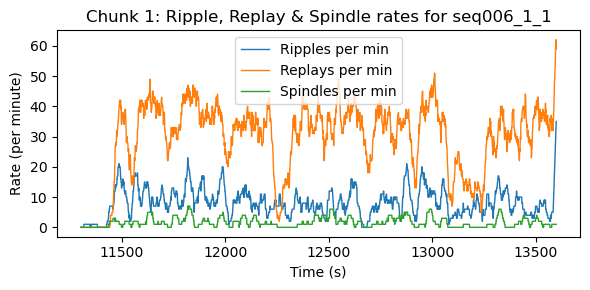

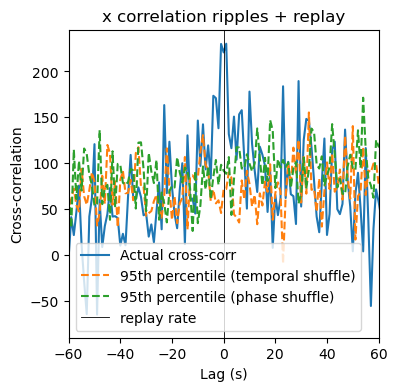

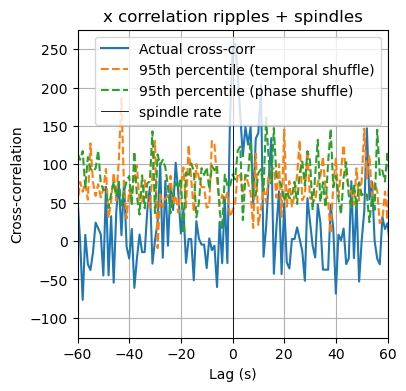

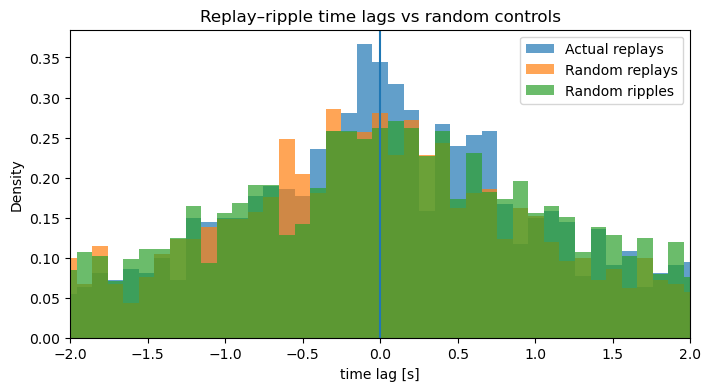

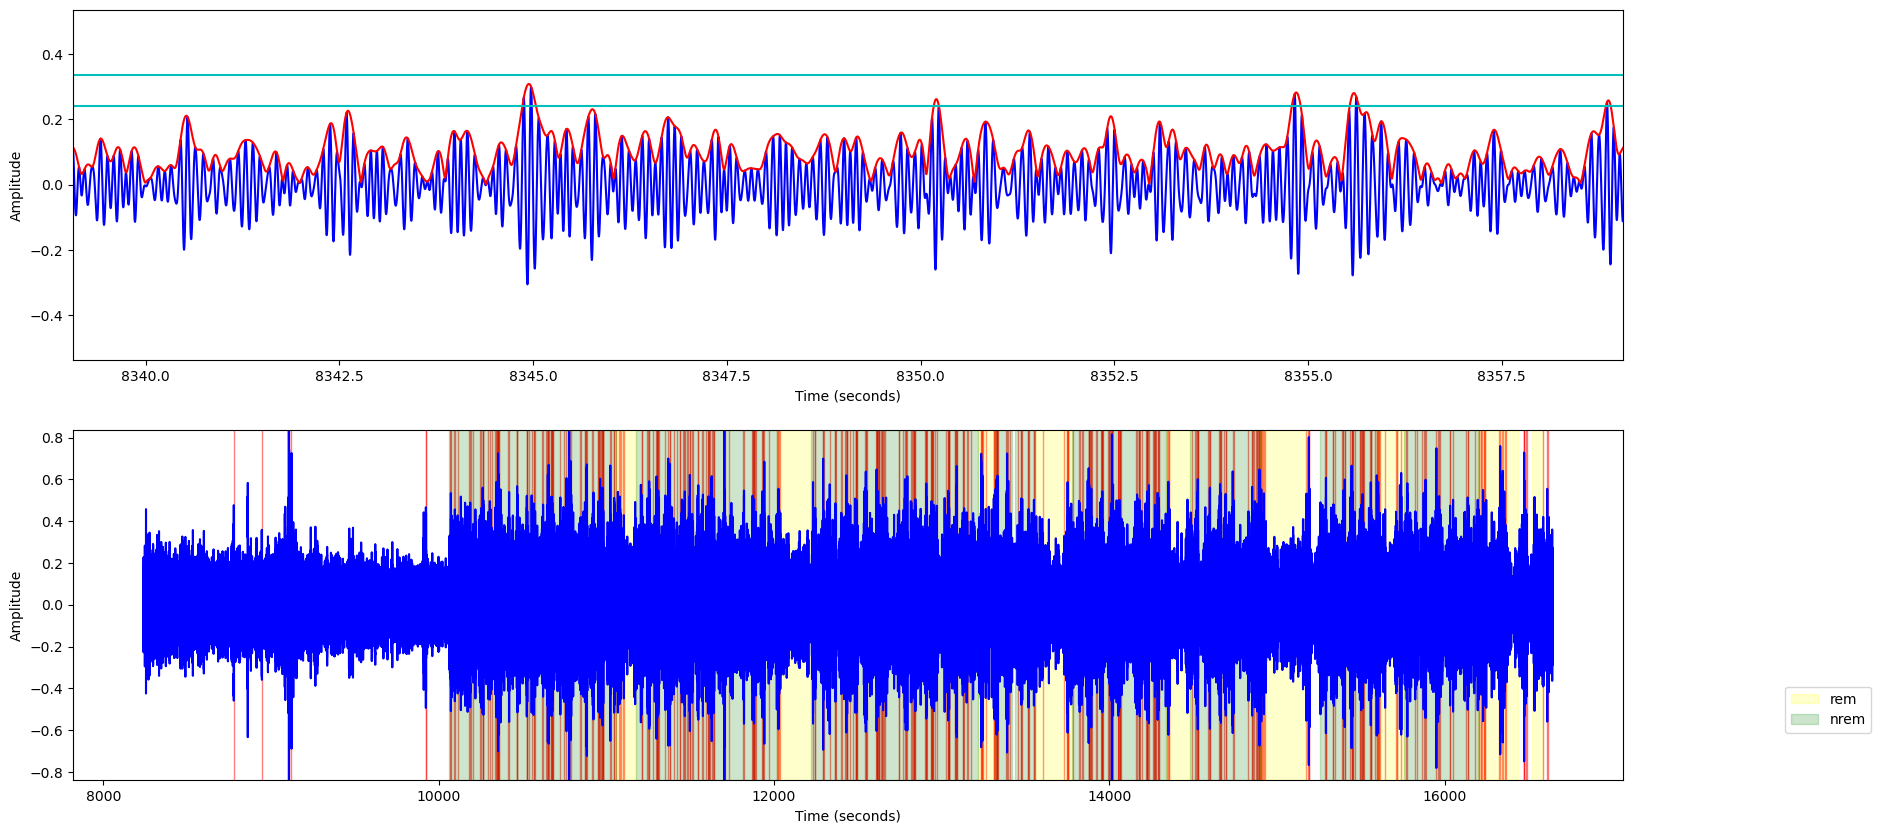

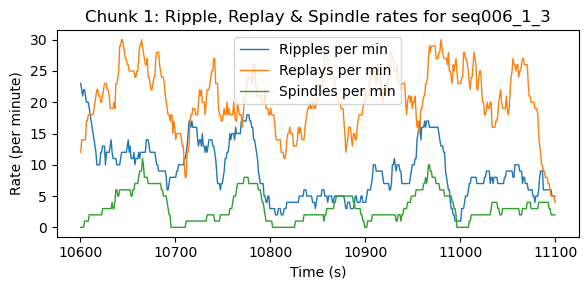

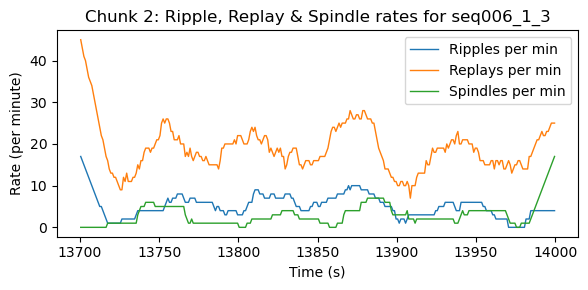

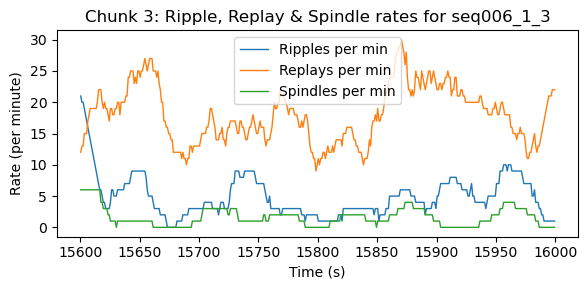

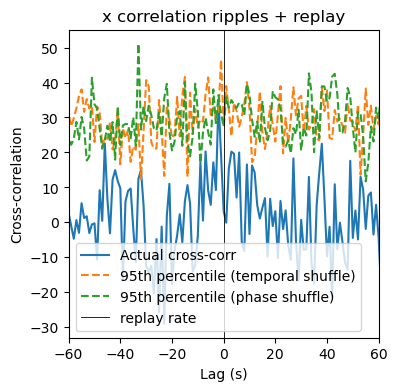

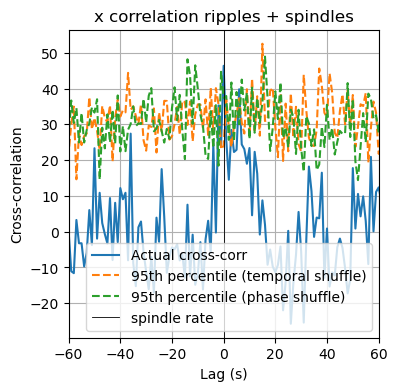

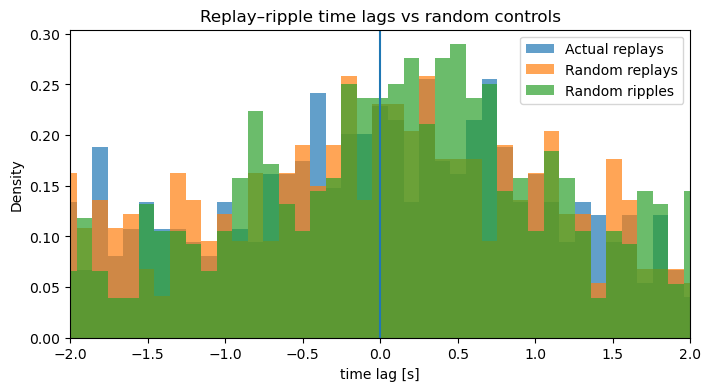

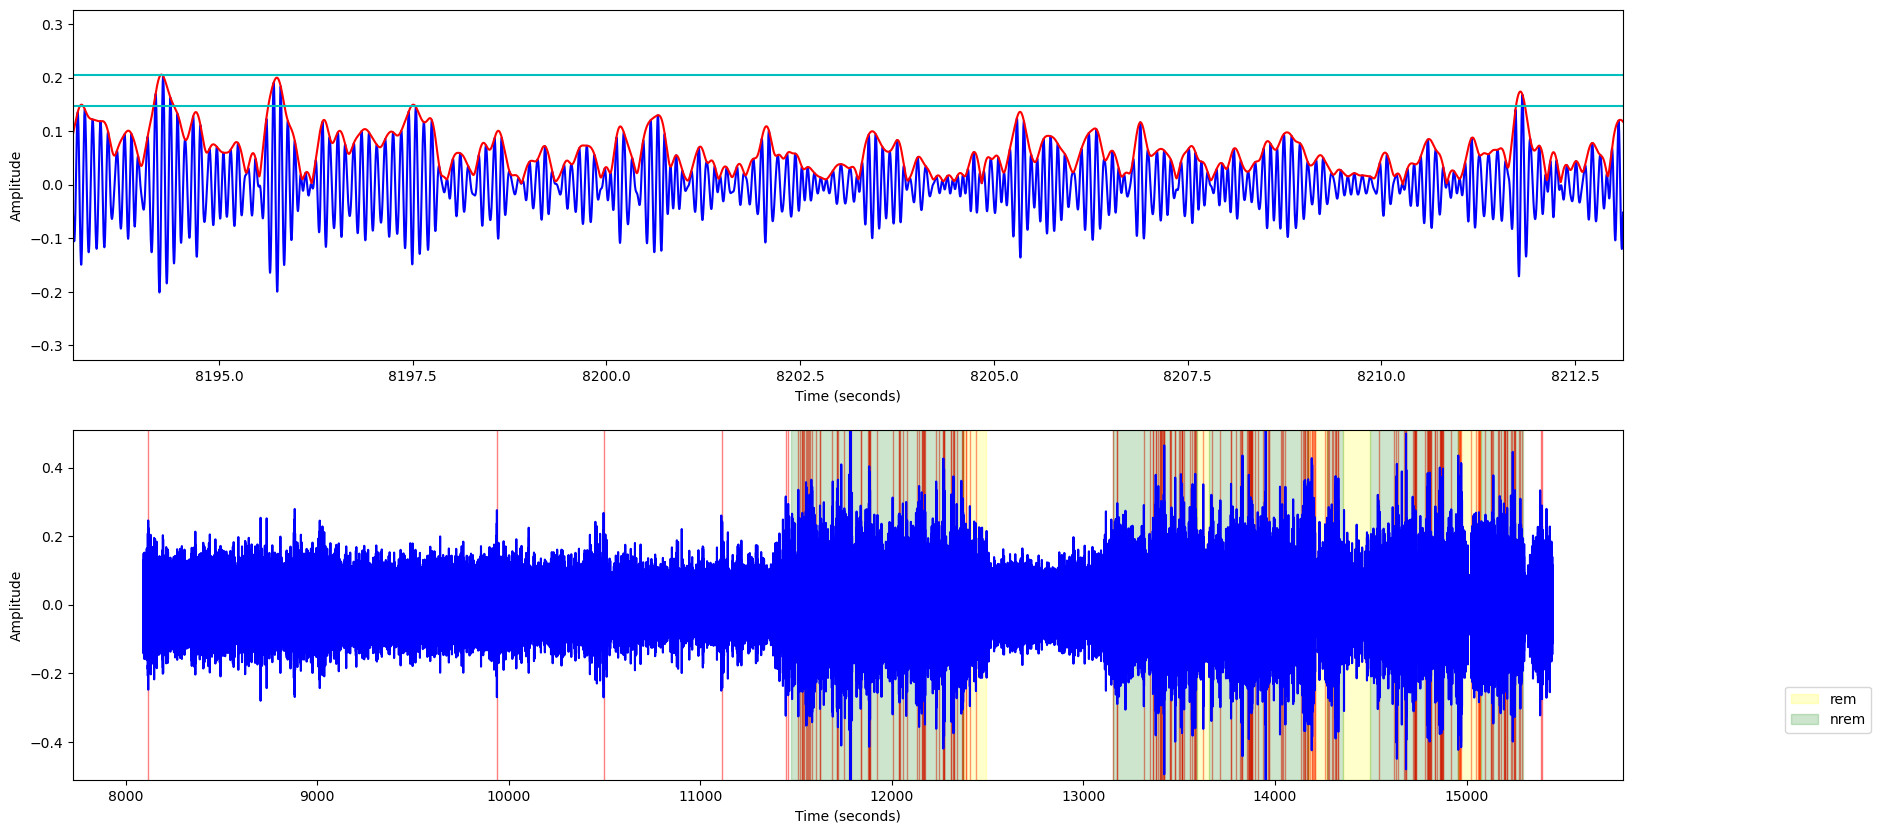

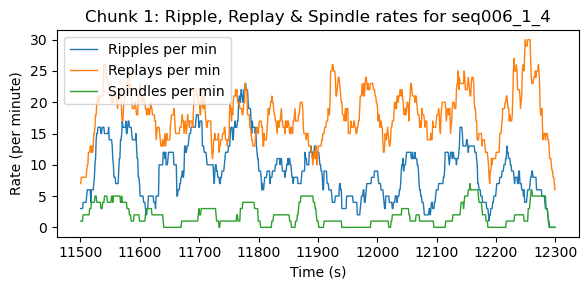

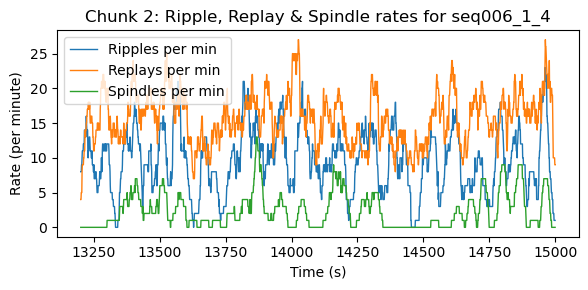

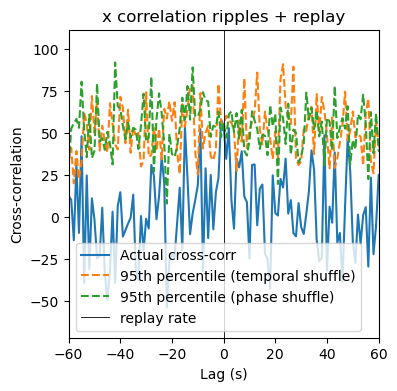

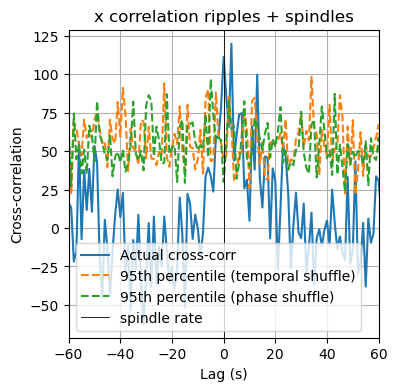

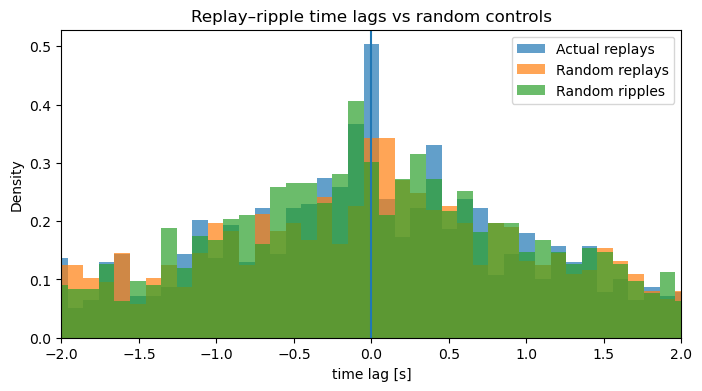

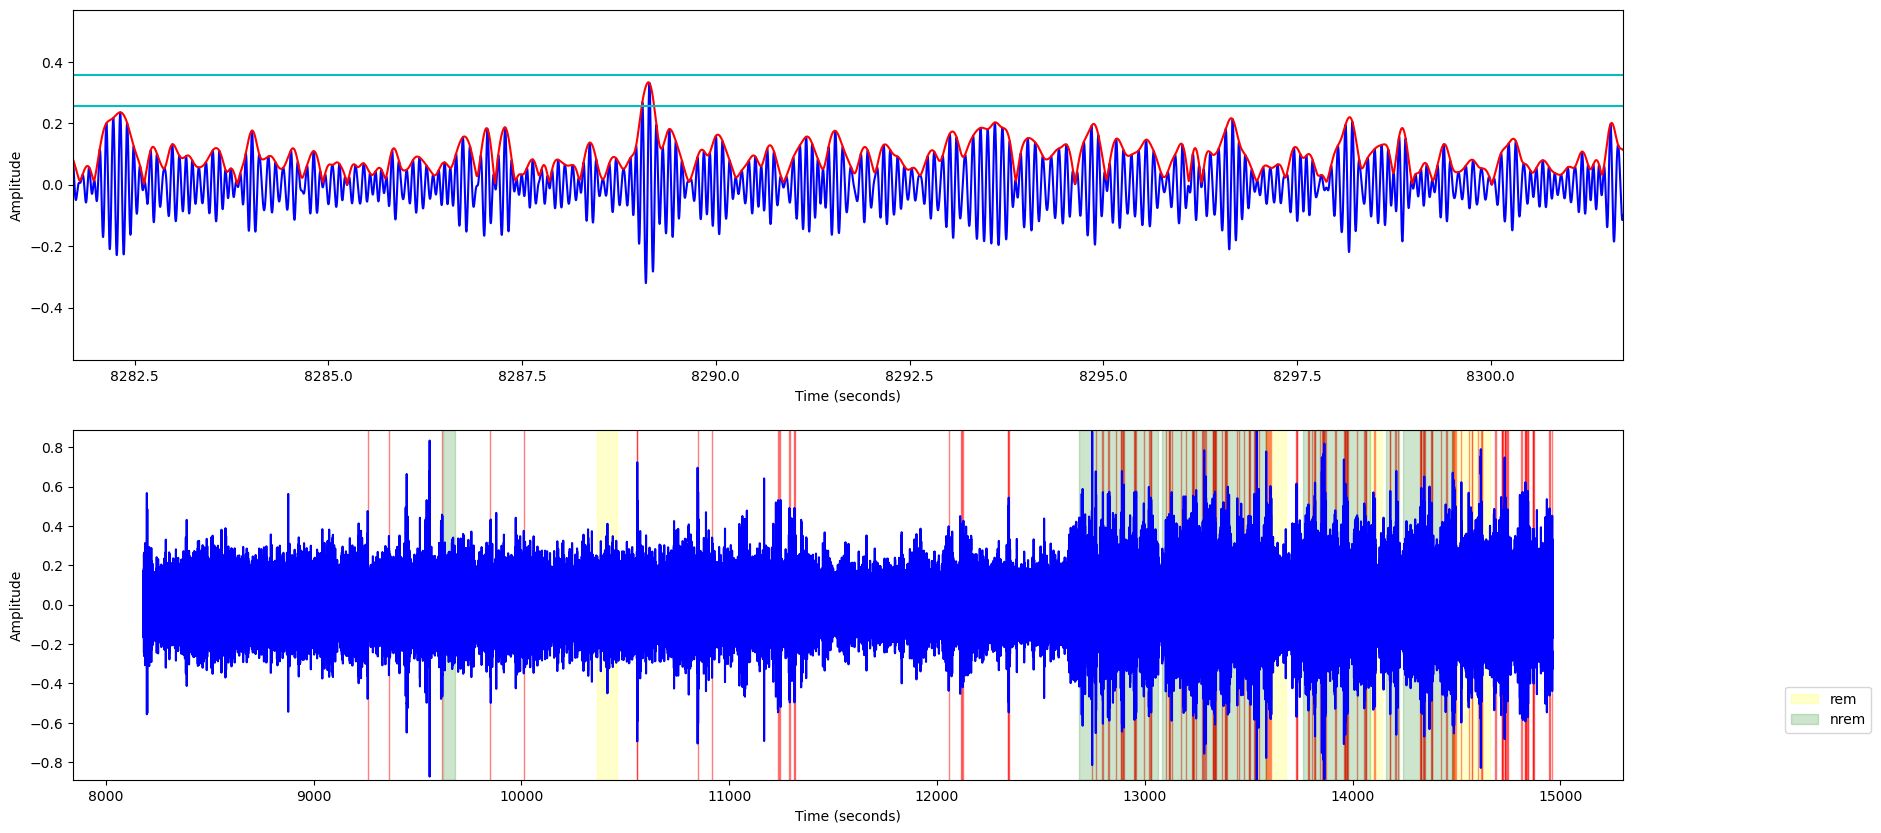

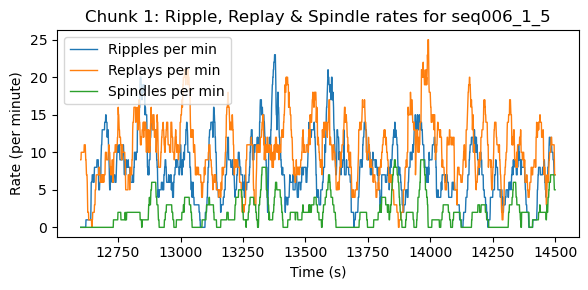

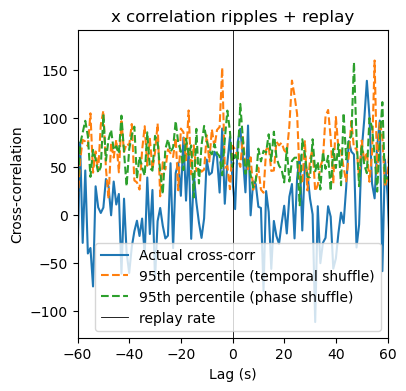

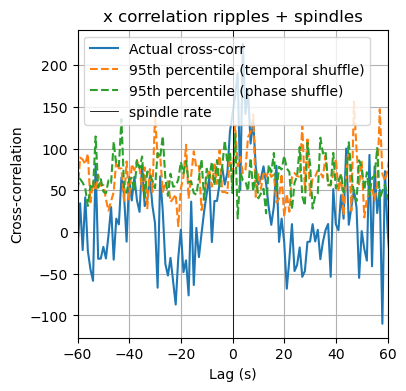

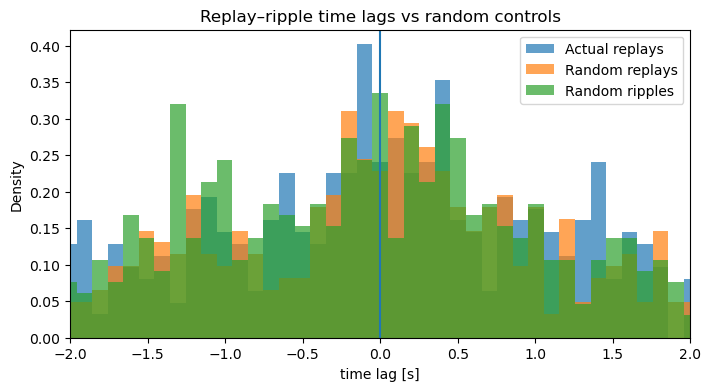

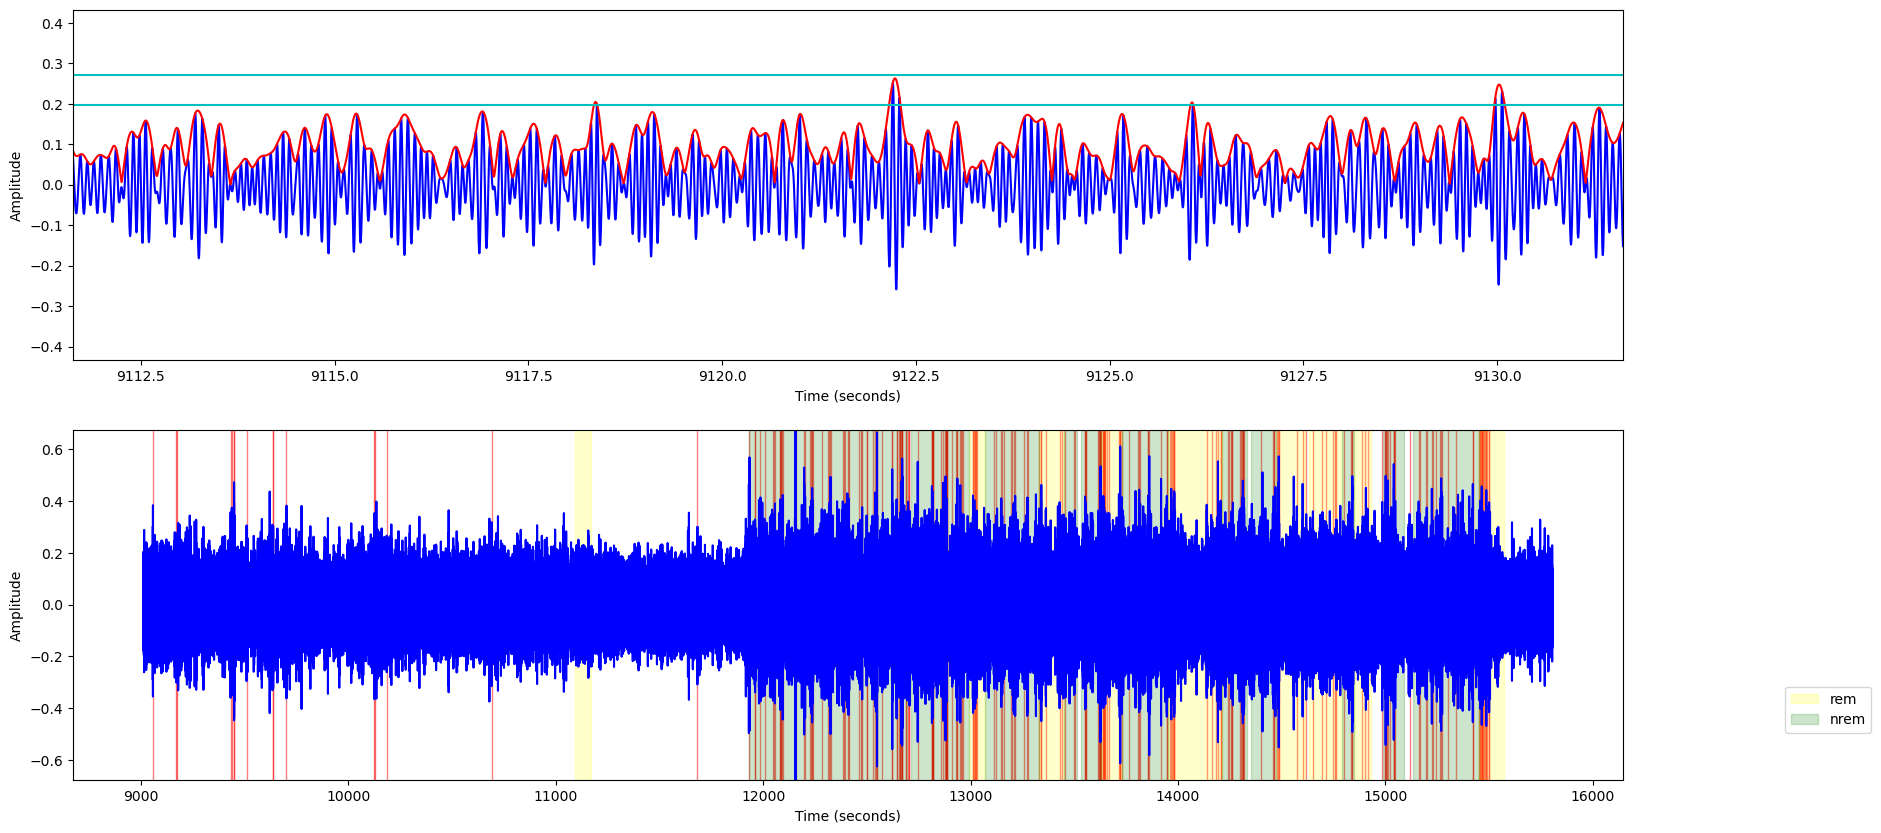

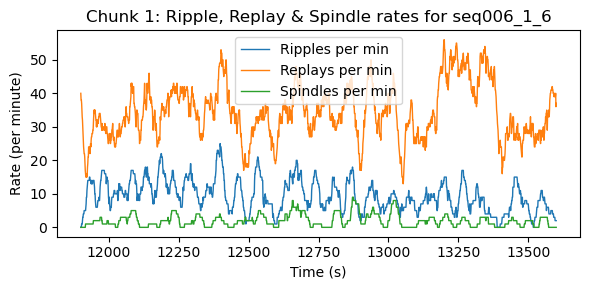

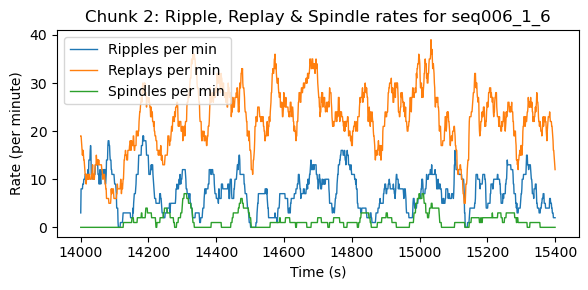

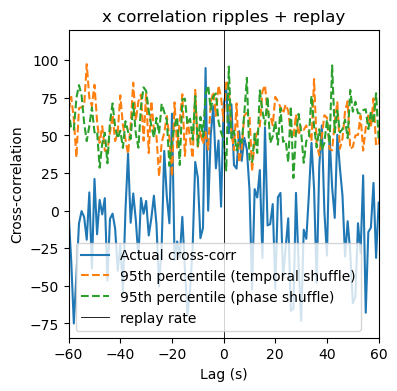

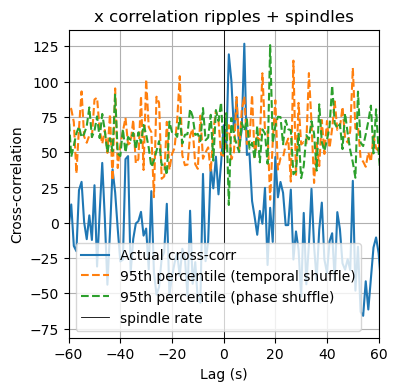

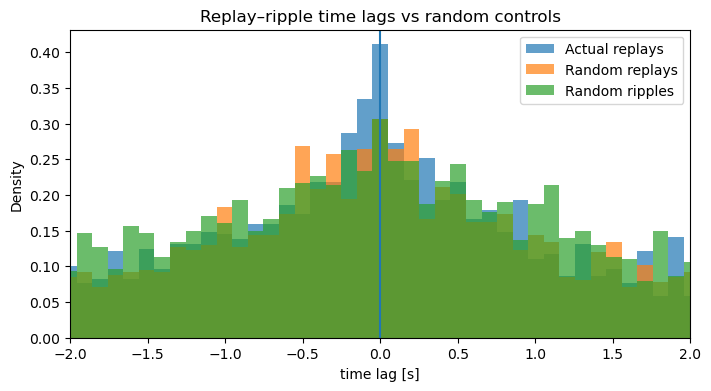

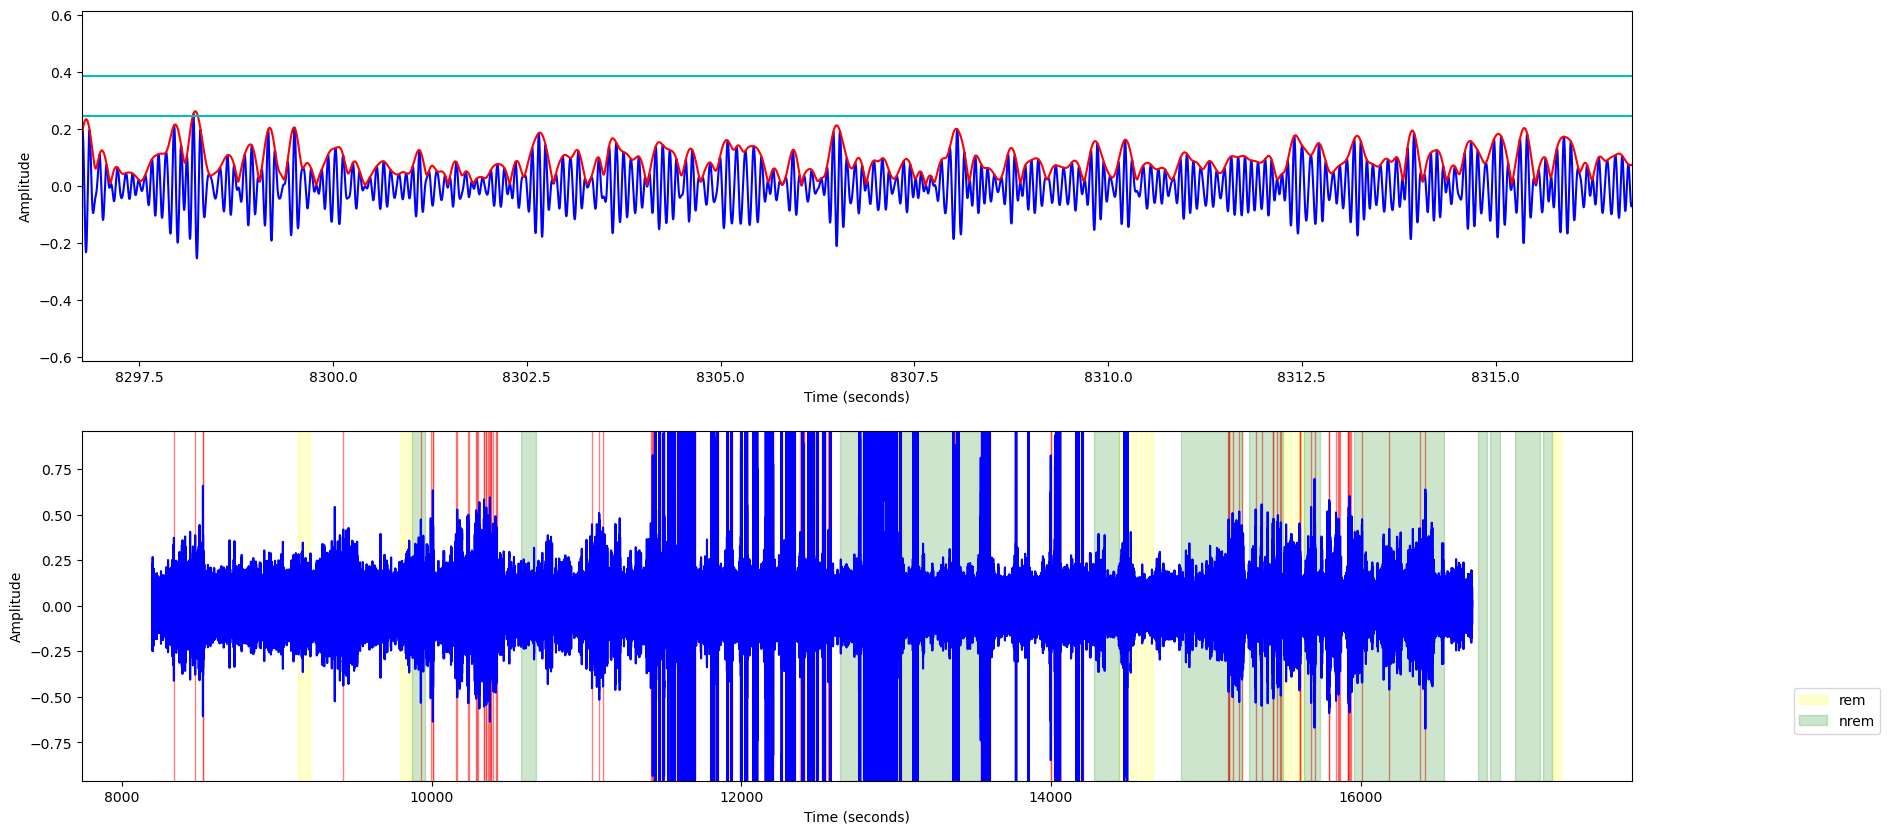

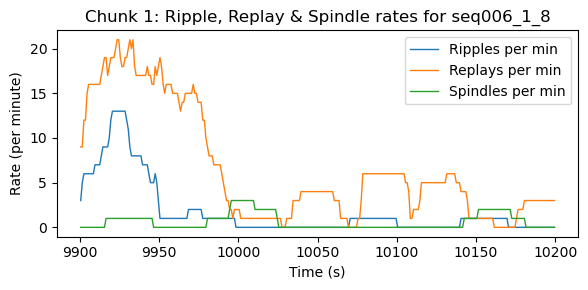

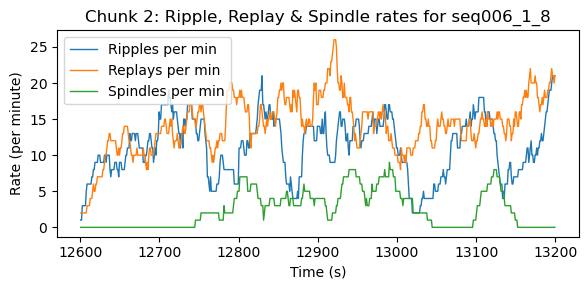

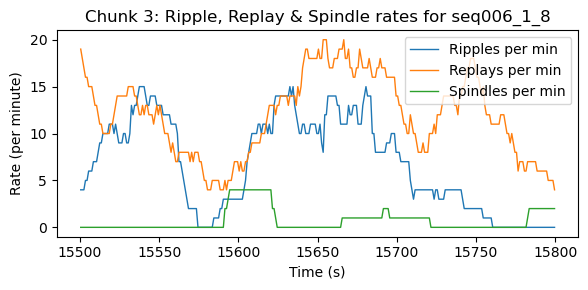

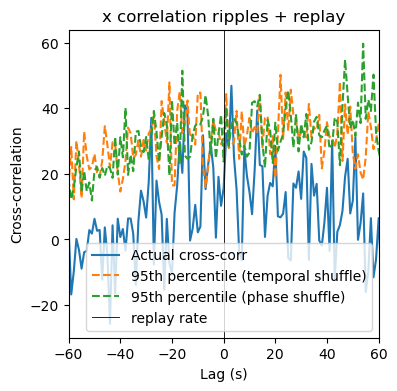

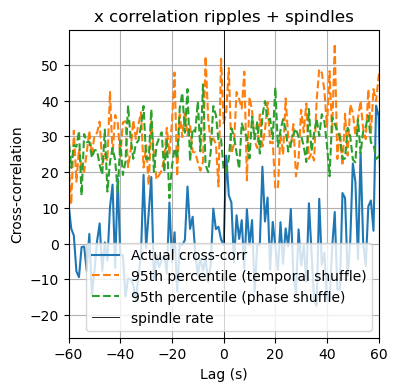

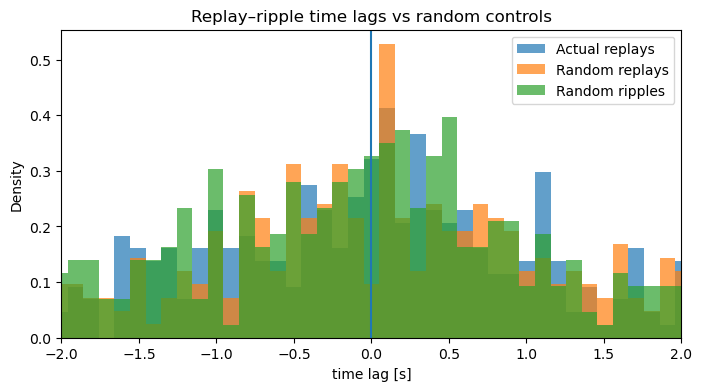

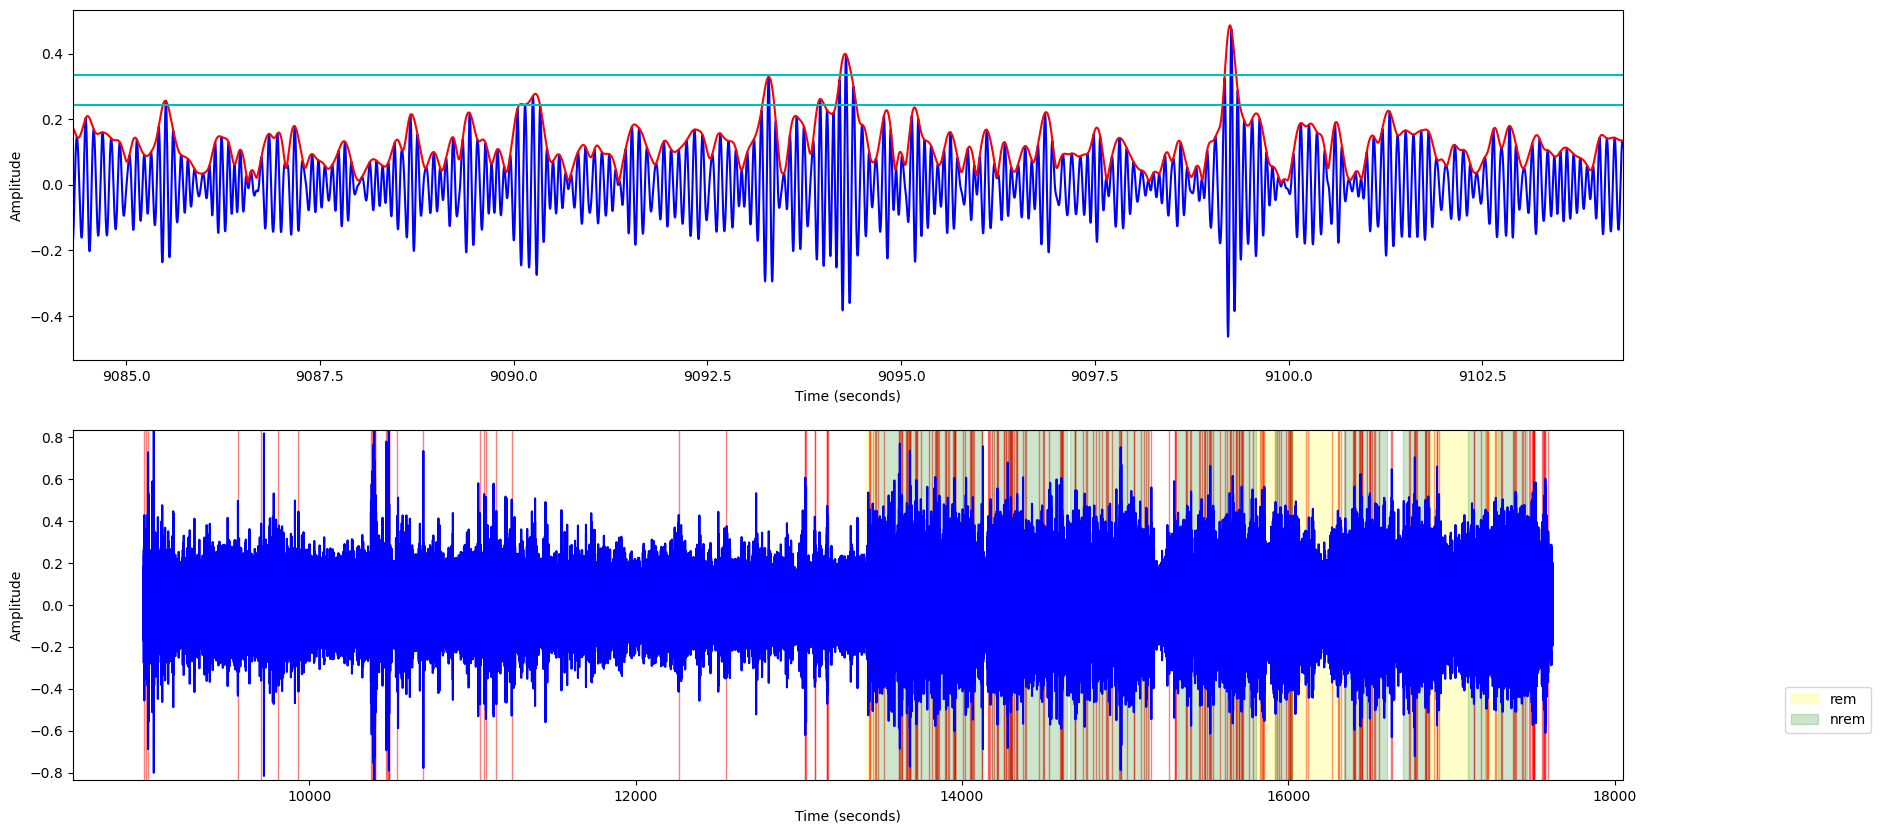

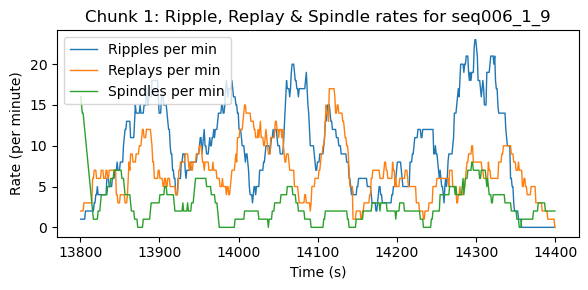

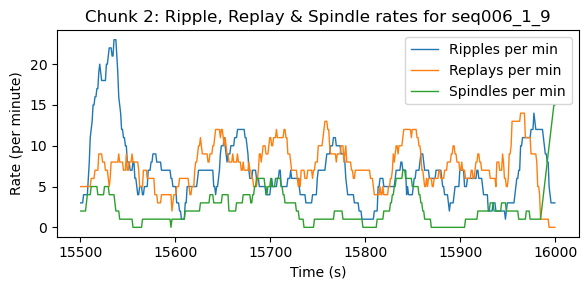

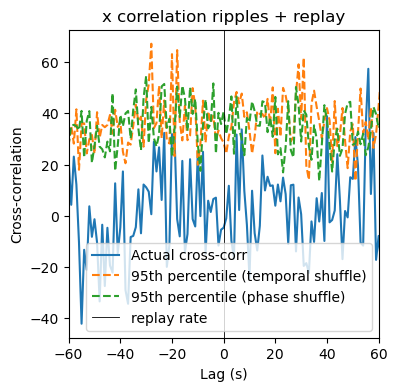

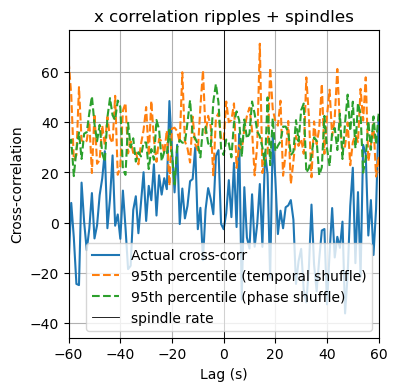

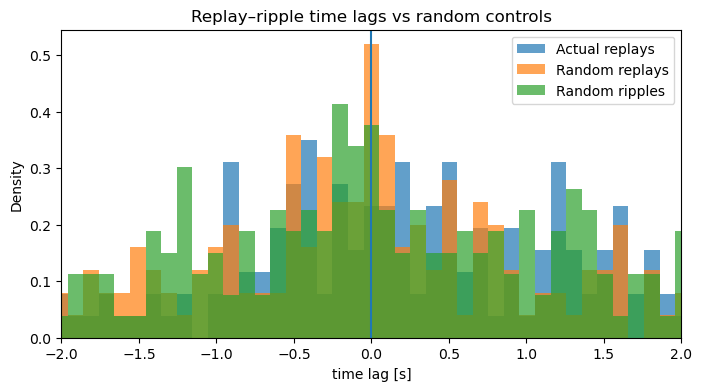

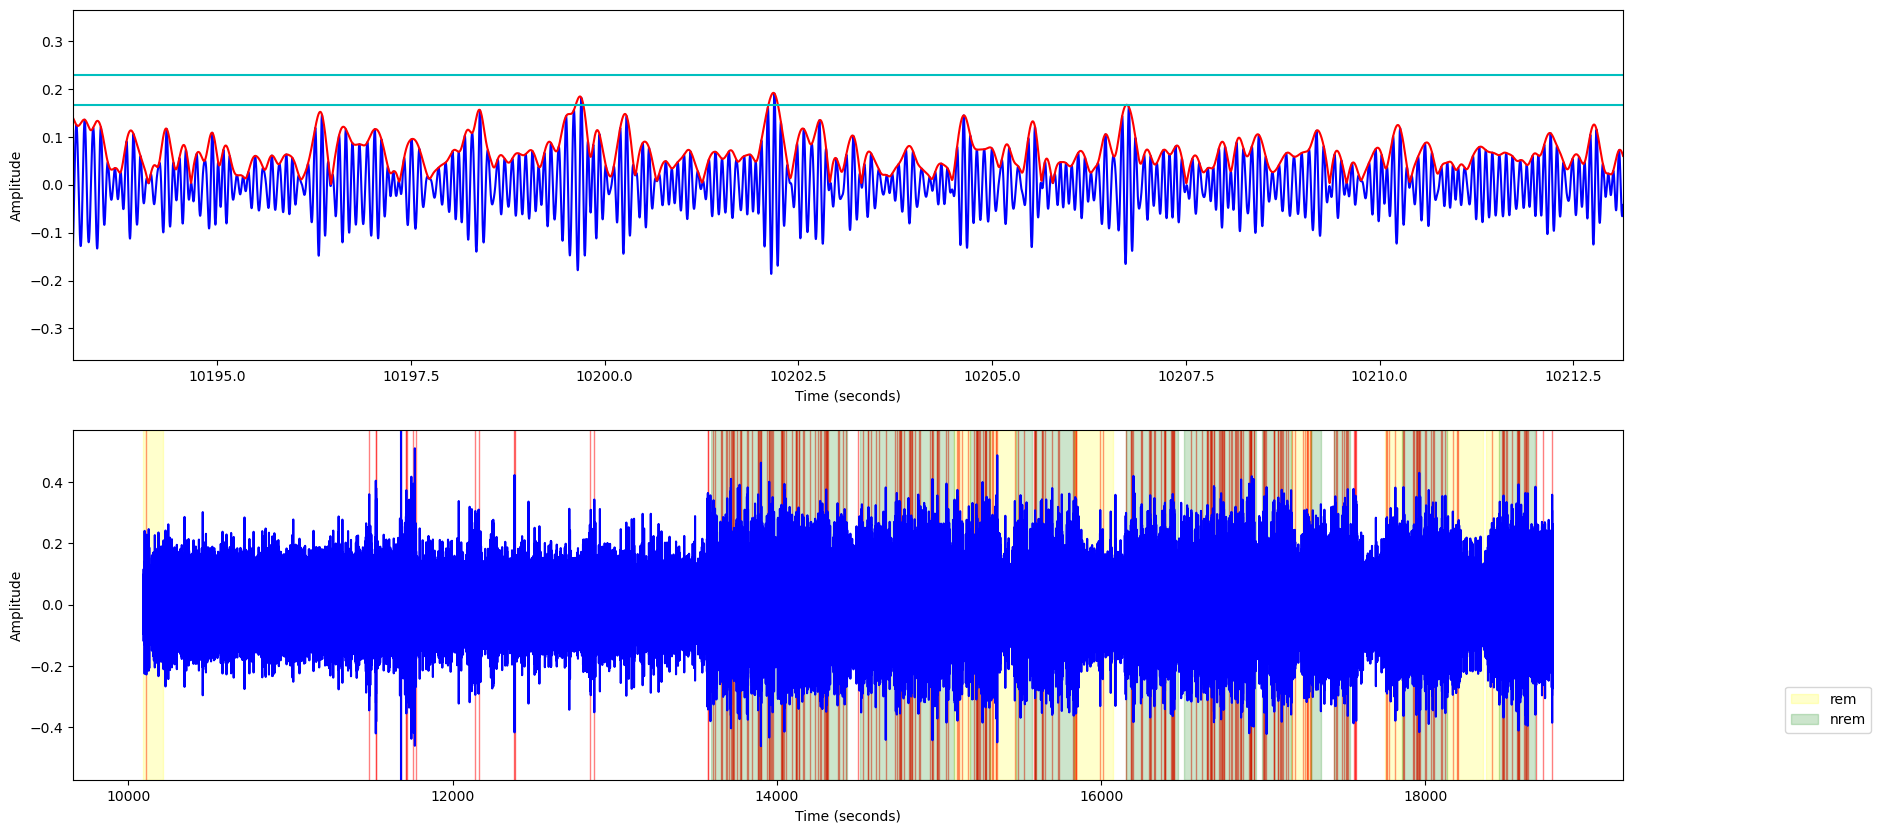

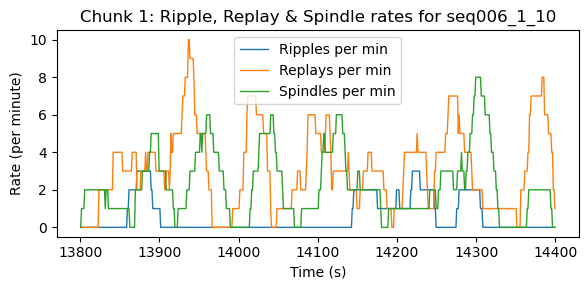

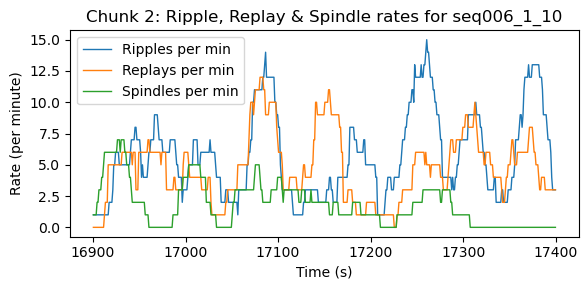

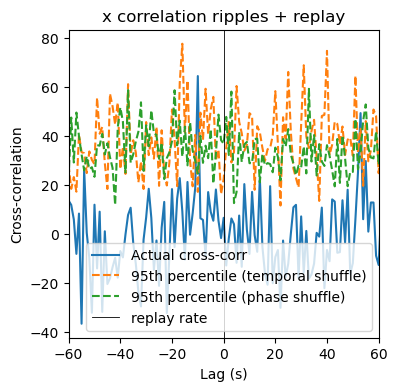

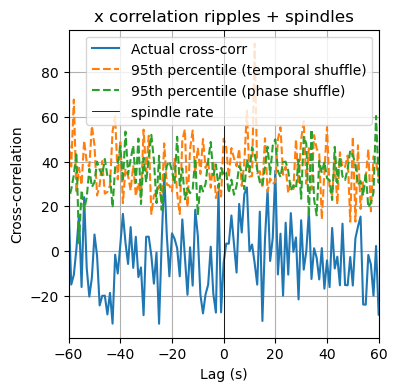

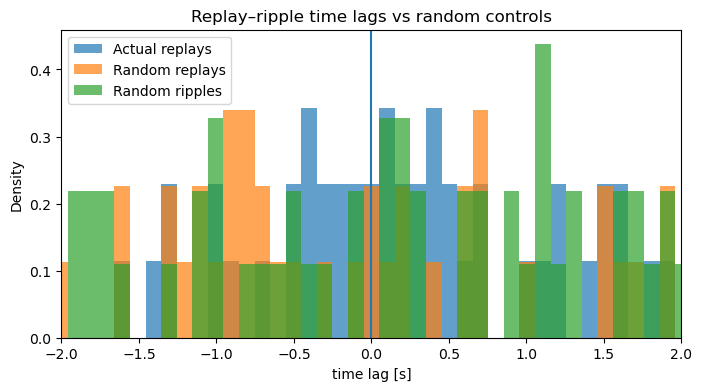

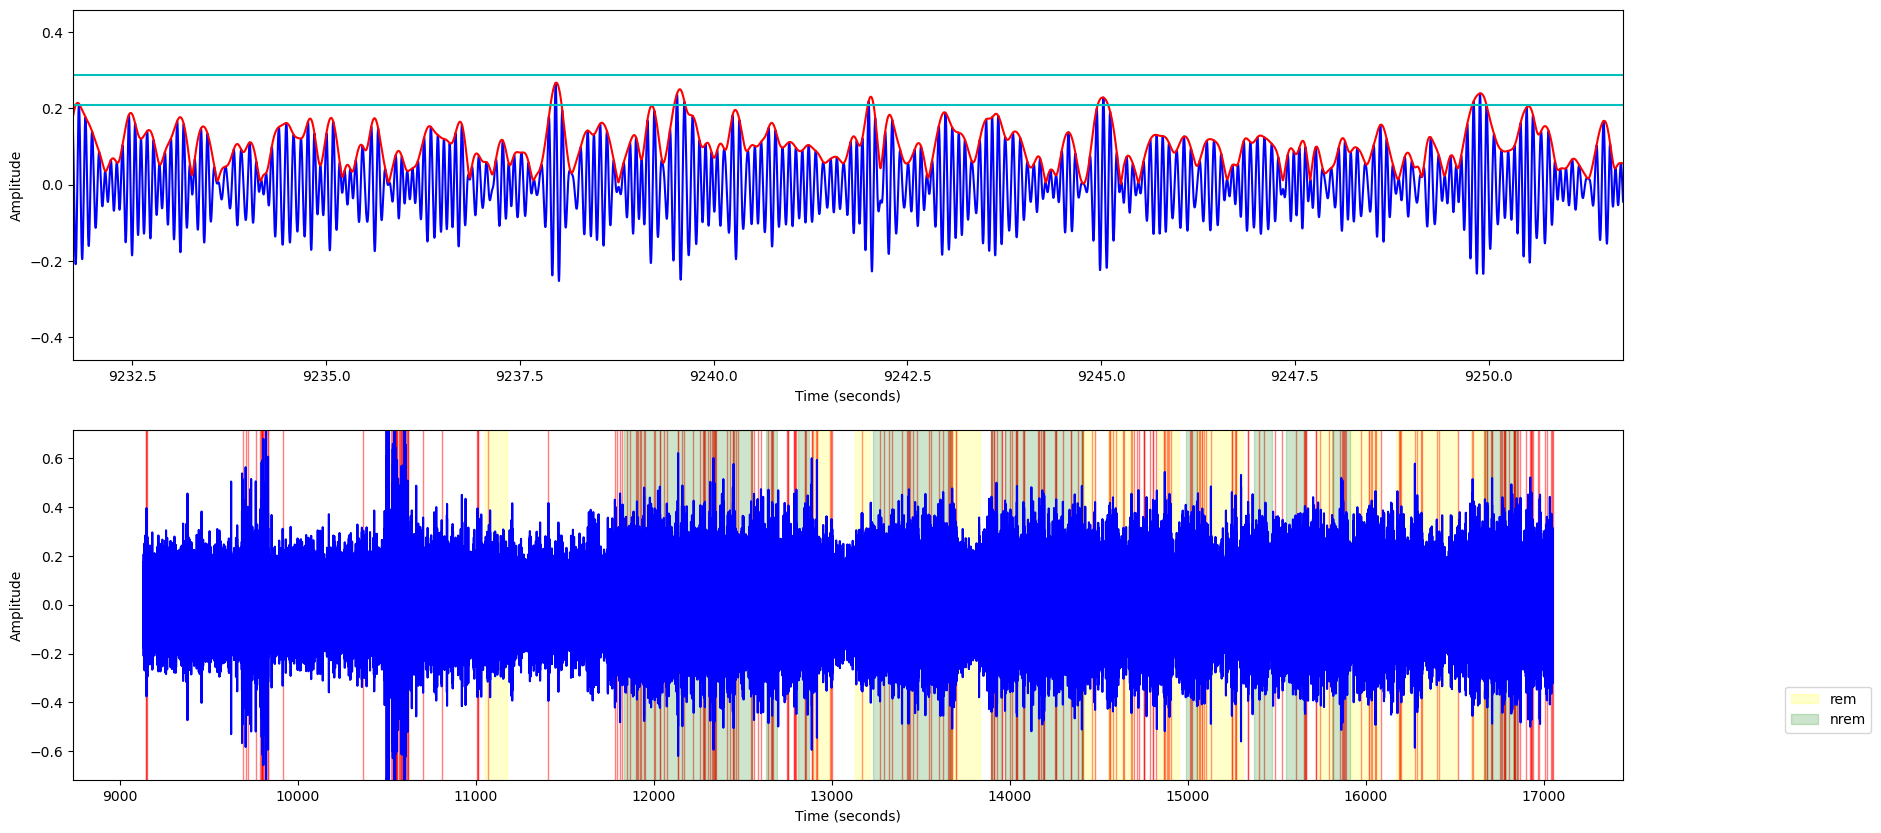

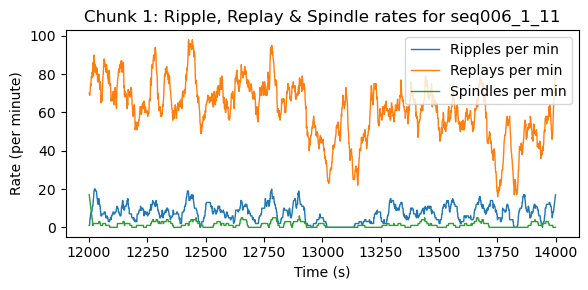

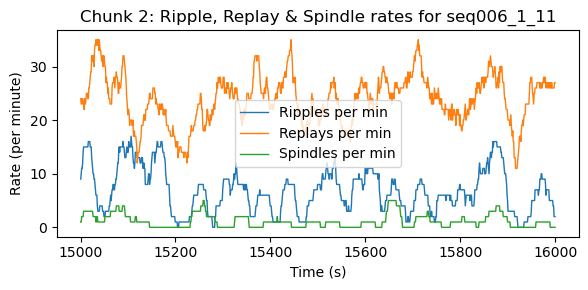

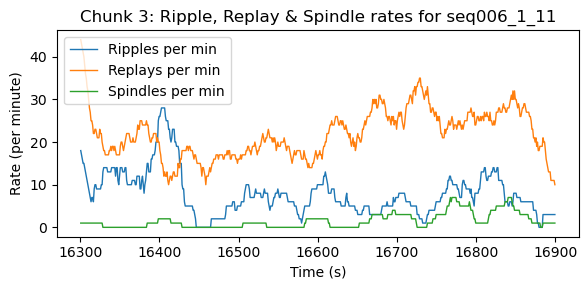

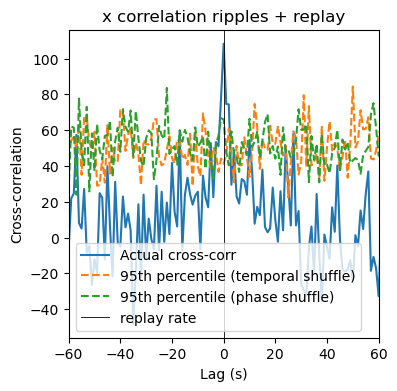

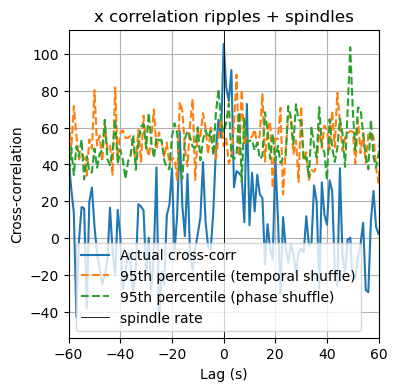

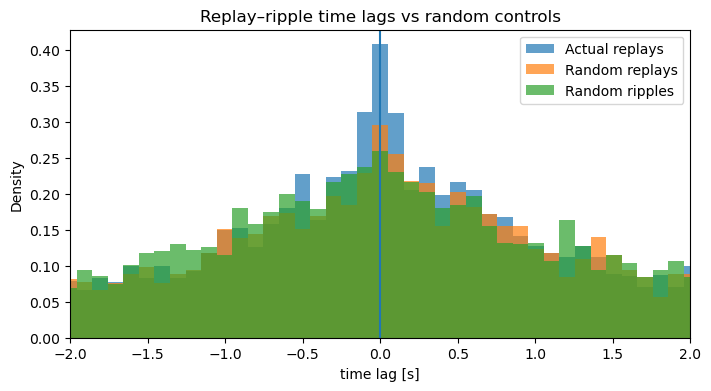

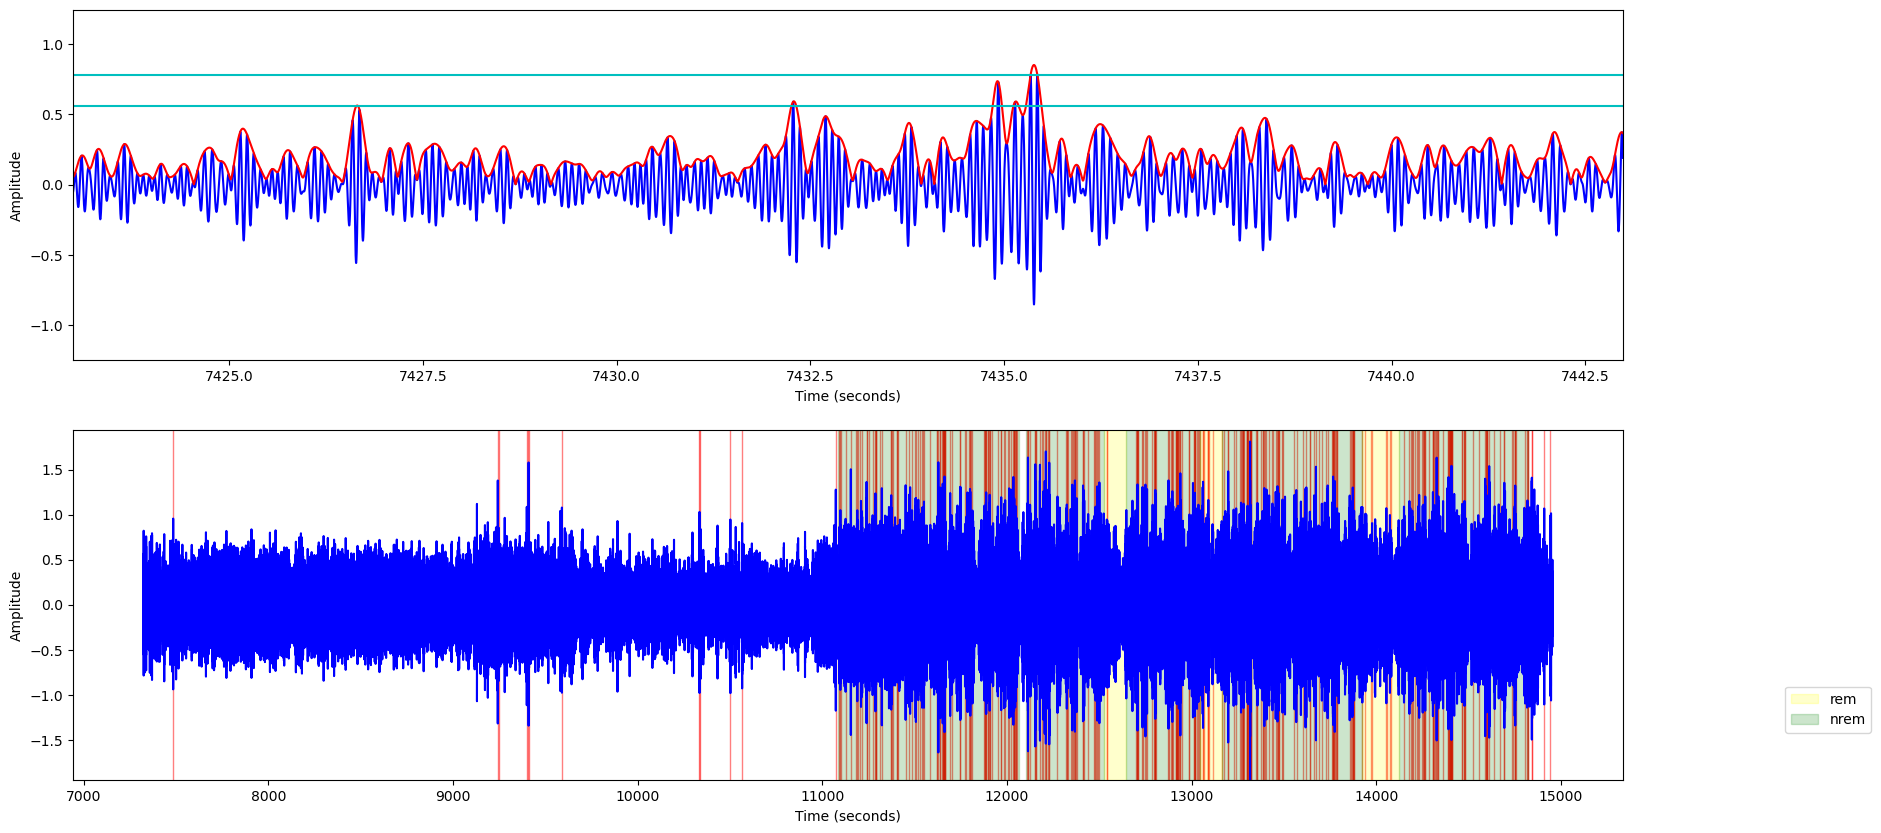

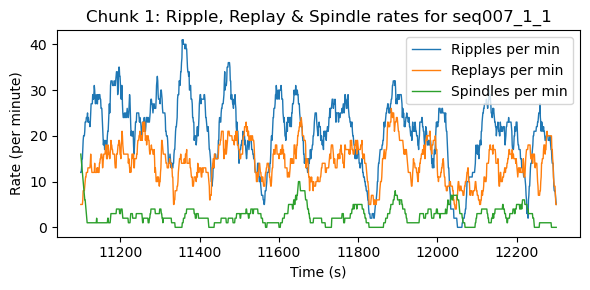

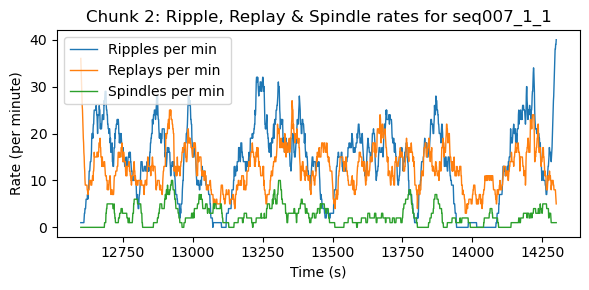

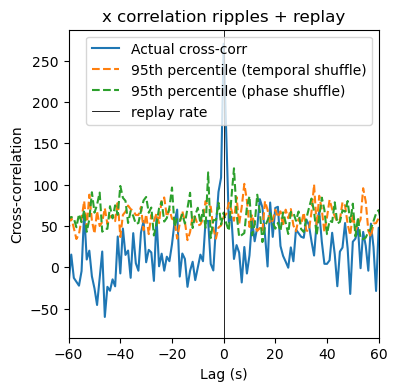

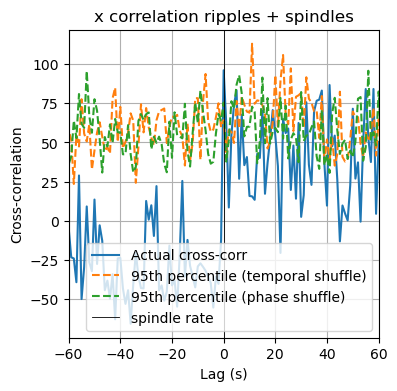

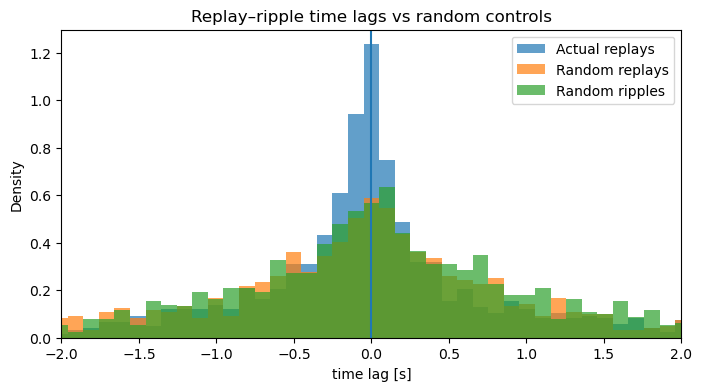

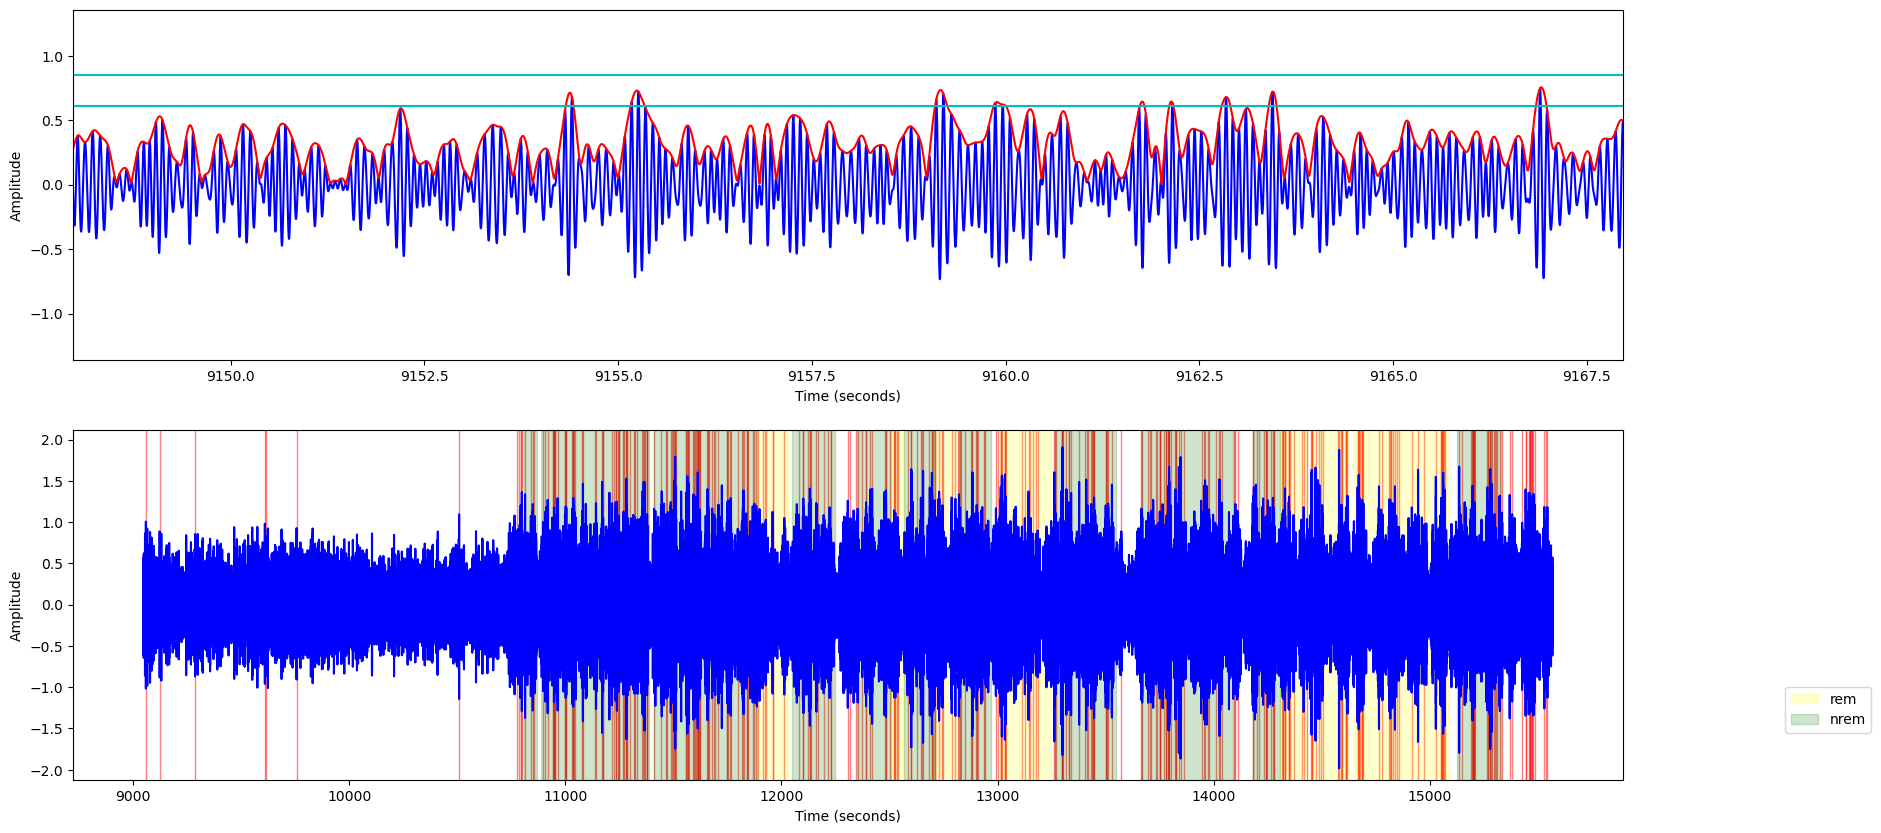

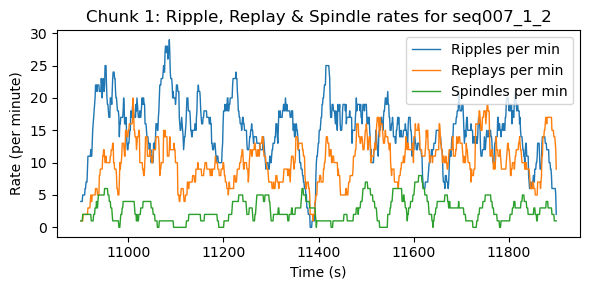

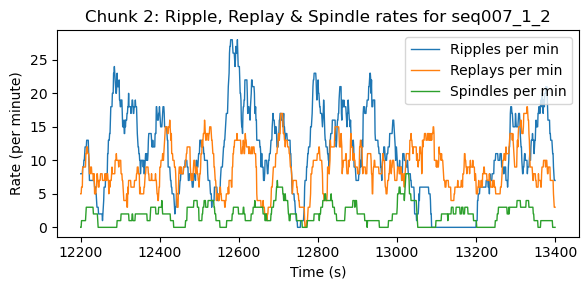

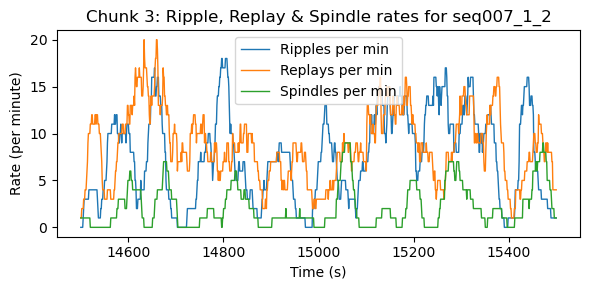

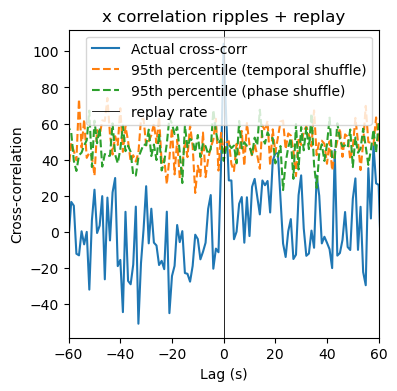

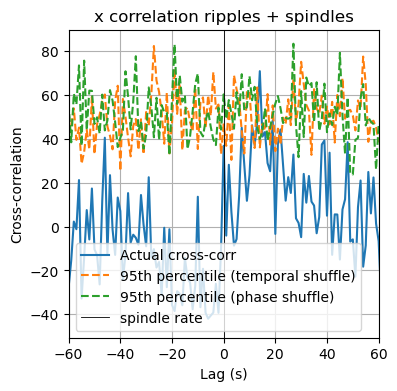

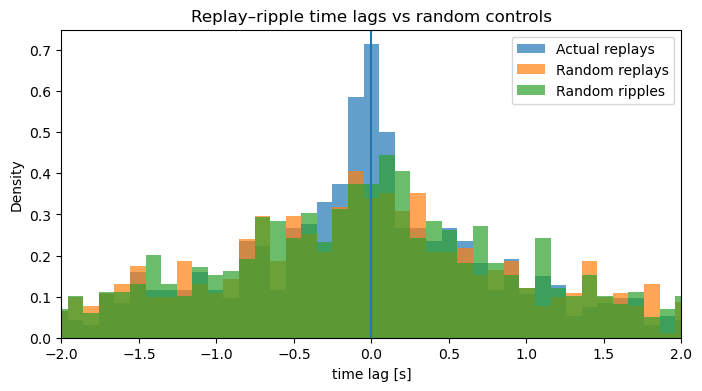

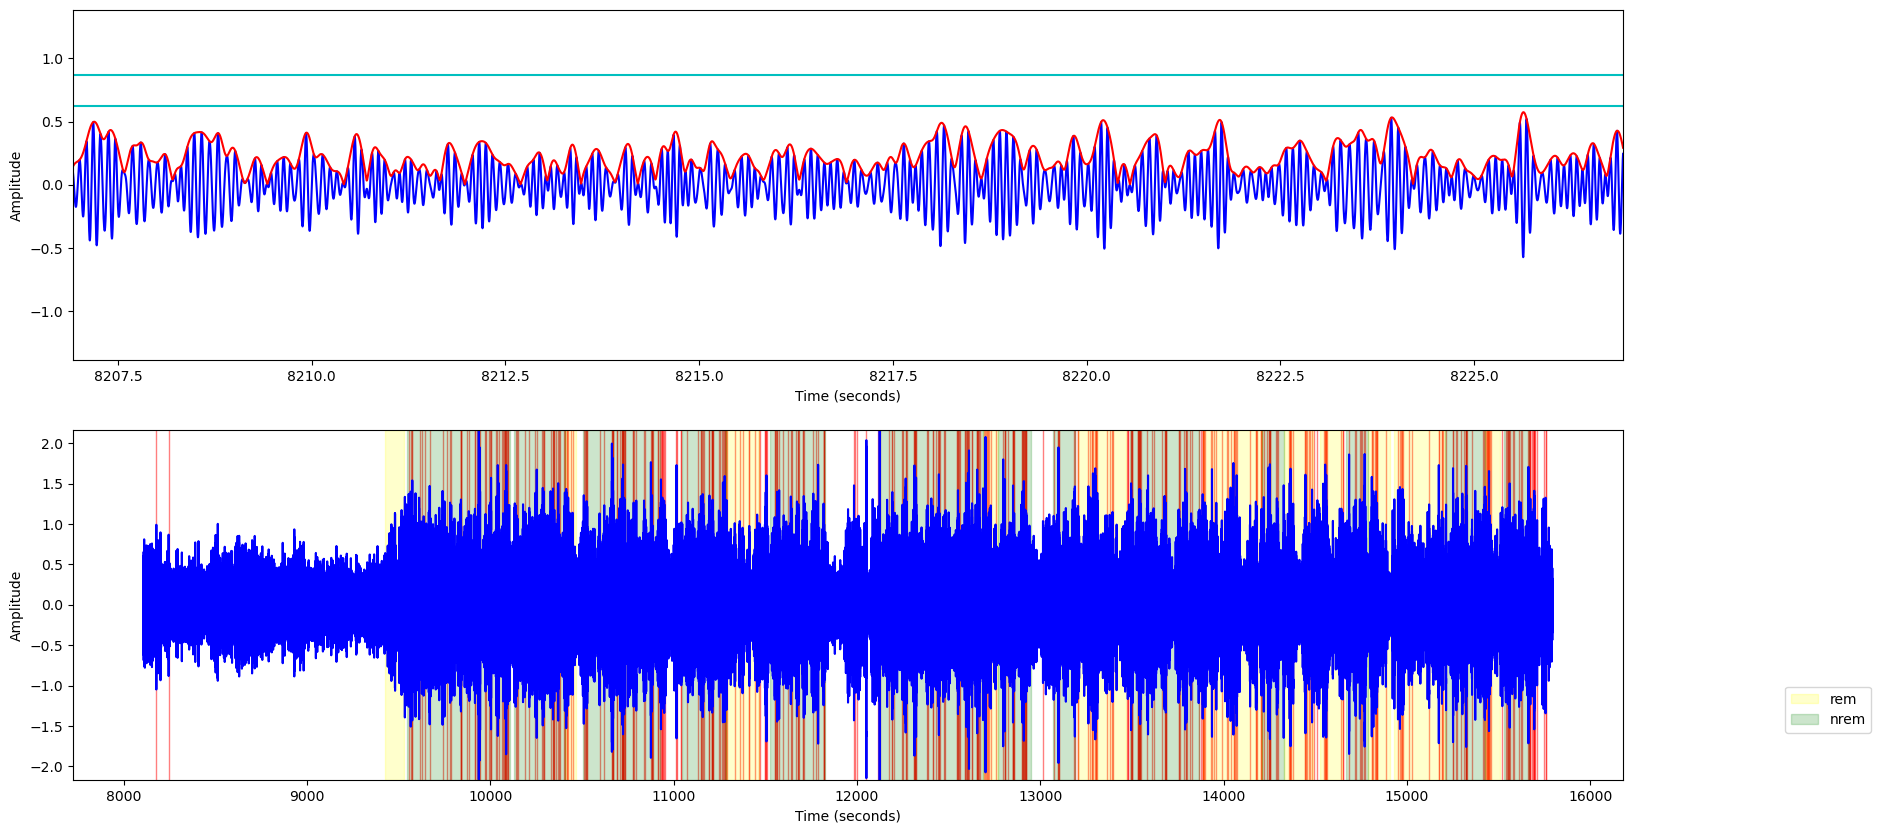

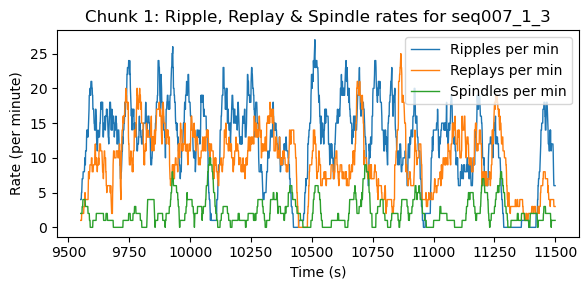

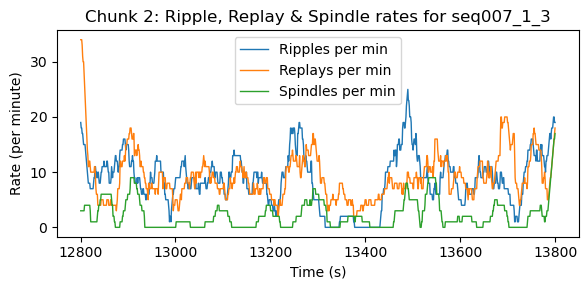

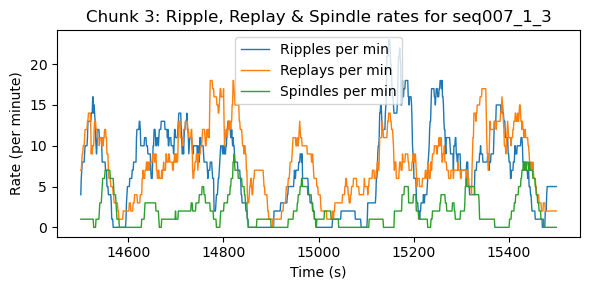

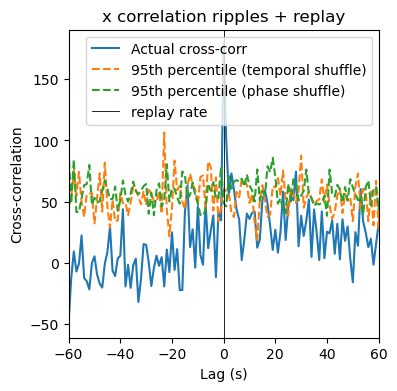

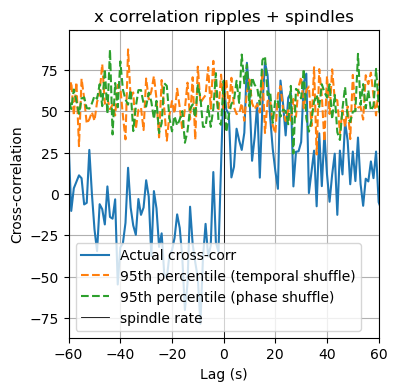

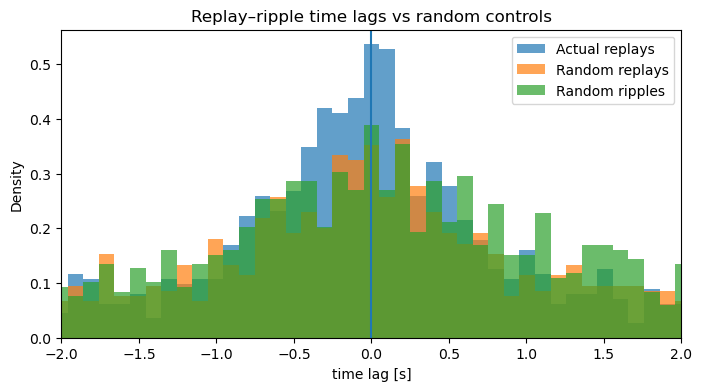

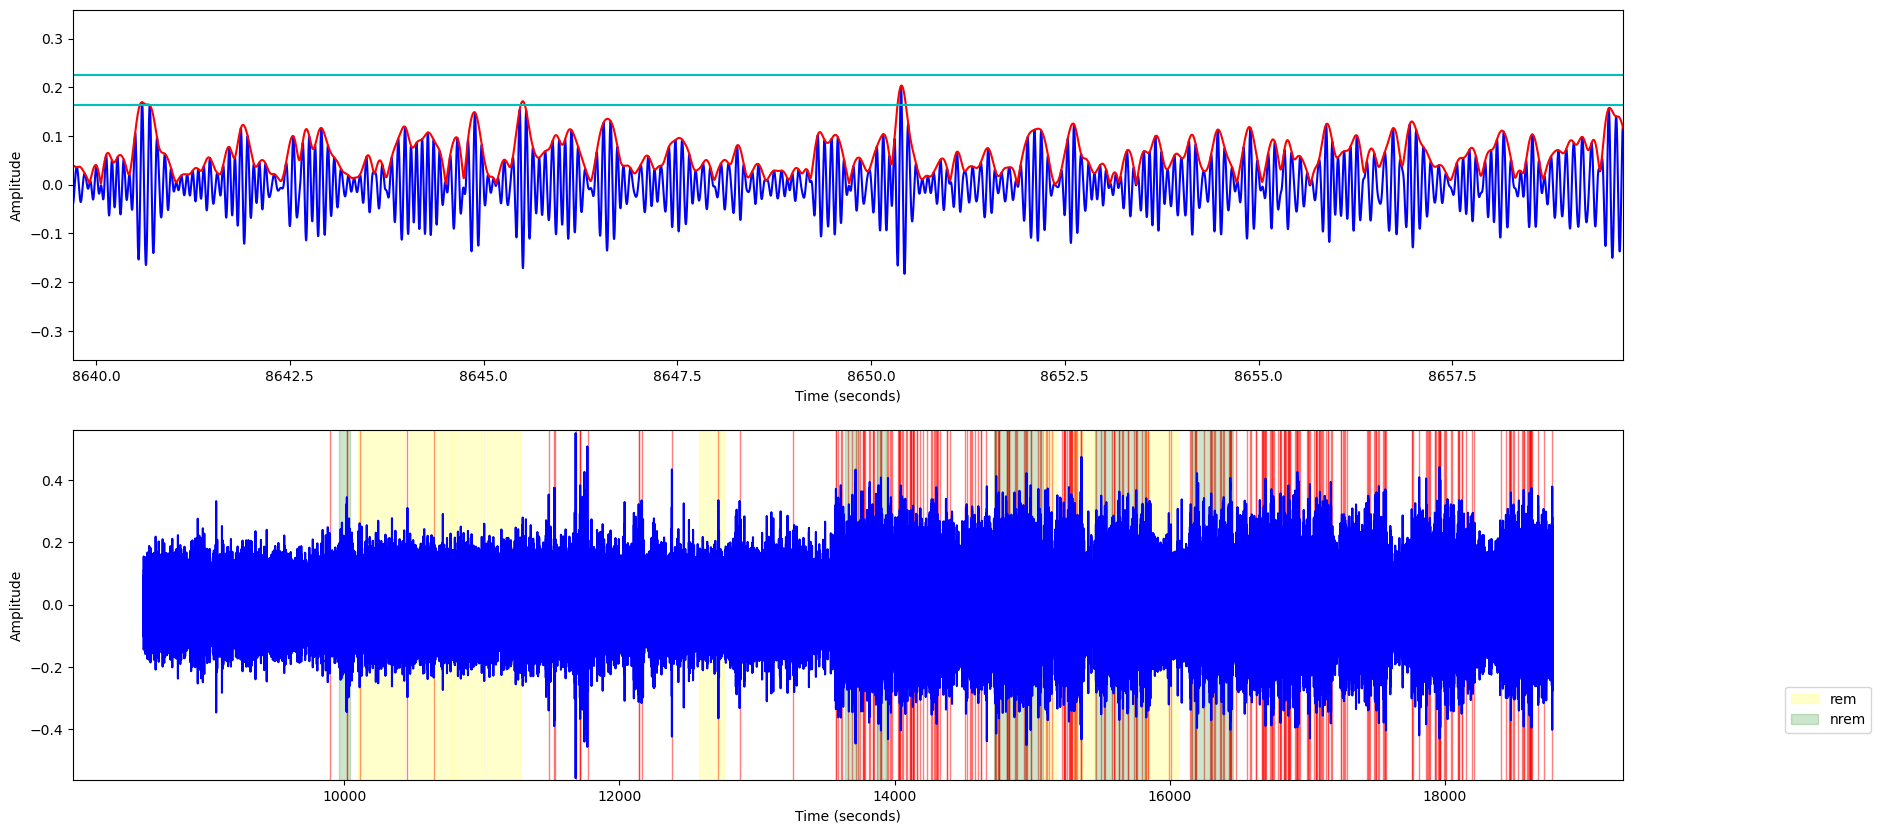

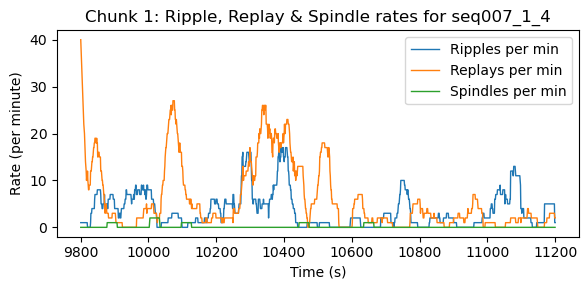

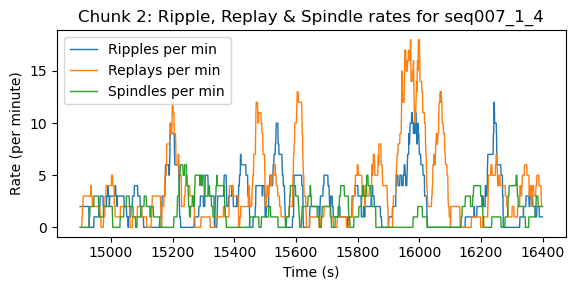

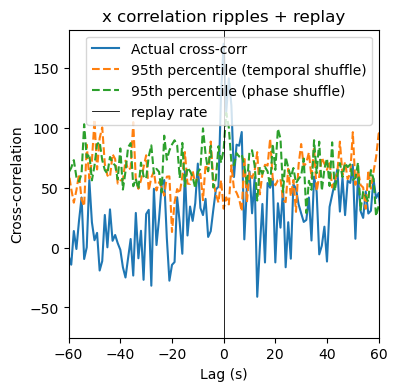

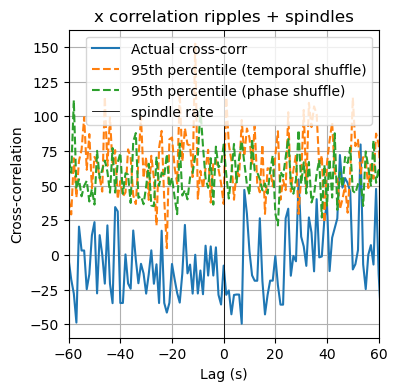

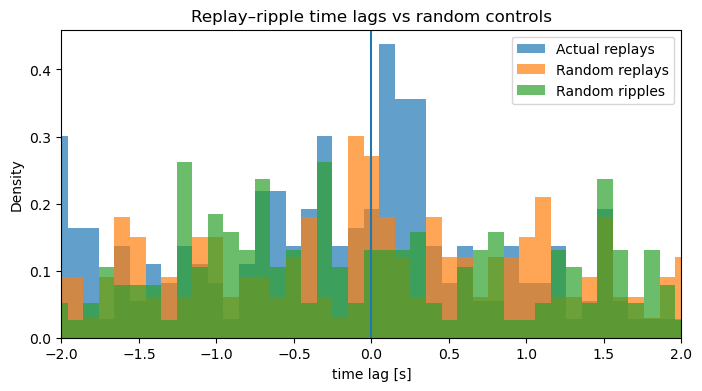

In [177]:
all_mice = ['seq006_1_1','seq006_1_3','seq006_1_4','seq006_1_5','seq006_1_6','seq006_1_8','seq006_1_9','seq006_1_10','seq006_1_11','seq007_1_1','seq007_1_2','seq007_1_3','seq007_1_4'
,'seq008_1_3','seq120_1_1','seq120_1_2','seq120_1_3','seq120_1_4','seq120_1_5','seq120_1_6','seq120_1_7','seq120_1_8']
ripples_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\hippocampus_lfp\processed_ripples\\"
out_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\hippocampus_lfp\ripple_analysis\\"

for current_mouse in all_mice:
    print(current_mouse)
    
    for mouse_file in os.listdir(ripples_path):
        
        # 1 RIPPLES #####
        if mouse_file.split('.csv')[0] == current_mouse:
            # import ripples for mouse
            print('ripples found')
            ripples_df = pd.read_csv(ripples_path + mouse_file)
        # import ripple info
        
    ## filter ripples for SWR linkage 
    SW_ripples_df = ripples_df[ripples_df.has_spw].reset_index()
    
    ######### LOAD USEFUL STUFF
    nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data_bool = load_in_sleep_state_scoring(current_mouse)
    # load sync file
    behav_sync_file = load_sync_file(mouse_org_data_path,mouse)
    # get the ephys time from the sleep because this is what the lfp was trimmed down to.                        
    sleep_period_ephys_start_time = behav_sync_file.Camera_time_Ephys_Aligned[0]
    
    # 2 SPINDLES ######## check if spindles exist already 
    lfp_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\dual_hpc_str\\" + current_mouse 
    try:
        spindle_events = np.load(lfp_path + r'\analysis\spindles_events.npy')
        print('spind events already found')
    except:
        print('spindle events not found - processing...')
        # load spindle bandpassed data and find spspindle...  
        spindle_bandpassed = np.load(lfp_path +r'\processed_data\zscored_spindle_bandpassed.npy')
        # ripple IDENTIFICATION ##############################
        # find ripple events
        fs = 2500
        min_event_duration = 0.3 #s
        spindle_events,smoothed_envelope = filter_for_spindles_and_plot(spindle_bandpassed,nrem_start_ends,rem_start_ends,fs,min_event_duration,sleep_period_ephys_start_time)
        if not os.path.exists(lfp_path + r'\\analysis\\'):
            os.makedirs(lfp_path + r'\\analysis\\')
        np.save(lfp_path + r'\analysis\spindles_events.npy',spindle_events)
        plt.savefig(lfp_path + r'\\analysis\spindle_identification.png')

    # 3 REPLAY ########### import replay info for mouse
    replay_path = r'Z:\projects\sequence_squad\ppseq_finalised_publication_data\dual_str_hpc\striatum\postsleep\\' 
    
    replay_events_df,chunk_spans= load_in_replay_data(current_mouse,replay_path,nrem_start_ends,rem_start_ends)


    # make data path
    full_out_path = out_path + current_mouse
    # create the directory if it doesn't exist
    os.makedirs(full_out_path, exist_ok=True)


    ############################ ripples per minute 
    ripples_per_minute = (len(SW_ripples_df.start_time.values) / max(SW_ripples_df.start_time.values)) * 60
    print(f"av ripple rate: {ripples_per_minute:.2f} per minute")

    # event start times in seconds
    times = SW_ripples_df.start_time.values
    # define sliding window
    window = 60   # seconds per window
    step = 10     # how much to slide each time (smaller = smoother curve)
    # create window start positions
    bins = np.arange(times.min(), times.max(), step)
    # count how many ripples occur in each window
    counts = np.array([
        np.sum((times >= b) & (times < b + window))
        for b in bins
    ])
    # convert to rate per minute (since window = 60s, this is same as counts)
    rates_per_minute = counts * (60 / window)
    # find min & max
    min_rate = rates_per_minute.min()
    max_rate = rates_per_minute.max()
    print(f"Lowest ripple rate: {min_rate:.2f} per minute")
    print(f"Highest ripple rate: {max_rate:.2f} per minute")
    
    np.save(full_out_path + '/ripple_rate_per_minute.npy',rates_per_minute)
    
    

    
    # SAVE THIS OUT! 

    #### CORRELATION EXAMPLES
    ripple_starts = SW_ripples_df.start_time + sleep_period_ephys_start_time
    replay_mids = replay_events_df.replay_abs_time
    spindle_starts = [event['start_time'] for event in spindle_events]

    # parameters
    bin_size = 1  # seconds
    chunk_ripple_counts = []
    chunk_replay_counts = []
    chunk_spindle_counts = []

    for i, (chunk_start, chunk_end) in enumerate(chunk_spans):
        # define bins for this chunk
        bins = np.arange(chunk_start, chunk_end + bin_size, bin_size)
        bin_centers = bins[:-1] + bin_size / 2

        # count events per bin
        ripple_counts, _ = np.histogram(ripple_starts, bins=bins)
        replay_counts, _ = np.histogram(replay_mids, bins=bins)
        spindle_counts, _ = np.histogram(spindle_starts, bins=bins)
        
        chunk_ripple_counts += [ripple_counts]
        chunk_replay_counts += [replay_counts]
        chunk_spindle_counts += [spindle_counts]

        # convert counts → rates per minute
        ripple_rate = ripple_counts * (30 / bin_size)
        replay_rate = replay_counts * (30 / bin_size)
        spindle_rate = spindle_counts * (30 / bin_size)

        # --- plot ---
        plt.figure(figsize=(6, 3))
        plt.plot(bin_centers,convolve_movmean(ripple_rate,30), label="Ripples per min", lw=1)
        plt.plot(bin_centers,convolve_movmean(replay_rate,30), label="Replays per min", lw=1)
        plt.plot(bin_centers,convolve_movmean(spindle_rate,30), label="Spindles per min", lw=1)
        plt.title(f"Chunk {i+1}: Ripple, Replay & Spindle rates for {current_mouse}")
        plt.xlabel("Time (s)")
        plt.ylabel("Rate (per minute)")
        plt.legend()
        plt.tight_layout()
        
    plt.savefig(full_out_path + '/correlation_examples.png')


    # CROSS CORRELLATION RIPPLES + REPLAY ########################################################################
    bin_duration_seconds = bin_size
    smoothing_window = 1
    cross_corrs, temp_shufs, phase_shufs, lags_samples_list, lags_seconds_list = calculate_cross_correlation(chunk_replay_counts,chunk_ripple_counts, smoothing_window,bin_duration_seconds,num_shuffles=10)

    # pick first chunk:
    x_seconds = np.array(np.mean(lags_seconds_list,axis = 0))
    y = np.array(np.mean(cross_corrs,axis = 0))
    y_shuf = np.array(np.mean(temp_shufs,axis = 0))
    y_shuf_2 = np.array(np.mean(phase_shufs,axis = 0))

    plt.figure(figsize=(4,4))
    plt.plot(x_seconds, y, label='Actual cross-corr')
    plt.plot(x_seconds, y_shuf, linestyle='--', label='95th percentile (temporal shuffle)')
    plt.plot(x_seconds, y_shuf_2, linestyle='--', label='95th percentile (phase shuffle)')
    plt.axvline(0, color='k', linewidth=0.6, label = 'replay rate')
    plt.xlabel('Lag (s)')            # or 'Lag (ms)' if you multiply by 1000
    plt.ylabel('Cross-correlation')
    plt.legend()
    plt.title('x correlation ripples + replay')
    plt.xlim(-60,60)
    
    plt.savefig(full_out_path + '/x_corr_ripples_replay.png')
    
    data_dict = {
    "x_seconds": x_seconds,
    "y": y,
    "y_shuf": y_shuf,
    "y_shuf_2": y_shuf_2
    }
    np.savez_compressed(os.path.join(full_out_path, "cross_corr_ripple_replay.npz"), **data_dict)
    
    # CROSS CORRELLATION RIPPLES + SPINDLES ########################################################################

    bin_duration_seconds = bin_size
    smoothing_window = 1
    cross_corrs, temp_shufs, phase_shufs, lags_samples_list, lags_seconds_list = calculate_cross_correlation(chunk_spindle_counts,chunk_ripple_counts, smoothing_window,bin_duration_seconds,num_shuffles=10)

    # pick first chunk:
    x_seconds = np.array(np.mean(lags_seconds_list,axis = 0))
    y = np.array(np.mean(cross_corrs,axis = 0))
    y_shuf = np.array(np.mean(temp_shufs,axis = 0))
    y_shuf_2 = np.array(np.mean(phase_shufs,axis = 0))

    plt.figure(figsize=(4,4))
    plt.plot(x_seconds, y, label='Actual cross-corr')
    plt.plot(x_seconds, y_shuf, linestyle='--', label='95th percentile (temporal shuffle)')
    plt.plot(x_seconds, y_shuf_2, linestyle='--', label='95th percentile (phase shuffle)')
    plt.axvline(0, color='k', linewidth=0.6, label = 'spindle rate')
    plt.xlabel('Lag (s)')            # or 'Lag (ms)' if you multiply by 1000
    plt.ylabel('Cross-correlation')
    plt.legend()
    plt.grid(True)
    plt.title('x correlation ripples + spindles')
    plt.xlim(-60,60)
    
    plt.savefig(full_out_path + '/x_corr_ripples_spindles.png')
    
    data_dict = {
    "x_seconds": x_seconds,
    "y": y,
    "y_shuf": y_shuf,
    "y_shuf_2": y_shuf_2
    }
    np.savez_compressed(os.path.join(full_out_path, "cross_corr_ripple_spindles.npz"), **data_dict)
    
    #################### LINKAGE ANALYSIS ###############
    
    relevant_ripples = []
    for span in chunk_spans:
        start, end = span[0], span[-1]
        mask = (ripple_starts > start) & (ripple_starts < end)
        relevant_ripples += list(ripple_starts[mask])
    relevant_ripples = np.array(relevant_ripples)
    replay_times = np.array(replay_mids)

    # --- 1️⃣ Actual
    diffs = relevant_ripples[None, :] - replay_times[:, None]
    nearest_idx = np.argmin(np.abs(diffs), axis=1)
    min_lags_actual = diffs[np.arange(len(replay_times)), nearest_idx]

    # --- 2️⃣ Randoms
    random_ripples, random_replays = [], []
    for span in chunk_spans:
        start, end = span[0], span[-1]

        mask_ripple = (ripple_starts > start) & (ripple_starts < end)
        n_ripples = np.sum(mask_ripple)
        mask_replay = (replay_times > start) & (replay_times < end)
        n_replays = np.sum(mask_replay)

        if n_ripples == 0 or n_replays == 0:
            continue

        random_ripples += list(np.random.uniform(start, end, n_ripples))
        random_replays += list(np.random.uniform(start, end, n_replays))

    random_ripples = np.array(random_ripples)
    random_replays = np.array(random_replays)

    # random replays
    diffs = relevant_ripples[None, :] - random_replays[:, None]
    nearest_idx = np.argmin(np.abs(diffs), axis=1)
    min_lags_rand_replay = diffs[np.arange(len(random_replays)), nearest_idx]

    # random ripples
    diffs = random_ripples[None, :] - replay_times[:, None]
    nearest_idx = np.argmin(np.abs(diffs), axis=1)
    min_lags_rand_ripples = diffs[np.arange(len(replay_times)), nearest_idx]

    # --- 3️⃣ Plot
    plt.figure(figsize=(8, 4))
    bins = np.linspace(-10, 10, 200)
    plt.hist(min_lags_actual, bins=bins, alpha=0.7, density=True, label="Actual replays")
    plt.hist(min_lags_rand_replay, bins=bins, alpha=0.7, density=True, label="Random replays")
    plt.hist(min_lags_rand_ripples, bins=bins, alpha=0.7, density=True, label="Random ripples")
    plt.xlabel("time lag [s]")
    plt.ylabel("Density")
    plt.legend()
    plt.title("Replay–ripple time lags vs random controls")
    plt.axvline()
    plt.xlim(-2,2)

    plt.savefig(full_out_path + '/linkage_lags_actual_vs_shuffle.png')

    data_dict = {
    "min_lags_actual": min_lags_actual,
    "min_lags_rand_replay": min_lags_rand_replay,
    "min_lags_rand_ripples": min_lags_rand_ripples,
    "bins": bins
    }
    np.savez_compressed(os.path.join(full_out_path, "linkage_lags_actual_vs_shuffle.npz"), **data_dict)



    ###### PROPORTION LINKED 

    prop_replay_linked_to_SWR = sum((abs(min_lags_actual) < 1.5)*1)/len(min_lags_actual)

    diffs = replay_times[None, :] - relevant_ripples[:, None]
    nearest_idx = np.argmin(np.abs(diffs), axis=1)
    min_lags_actual = diffs[np.arange(len(relevant_ripples)), nearest_idx]
    proportion_SWR_linked_to_replay = sum((abs(min_lags_actual) < 1.5)*1)/len(min_lags_actual)

    data_dict = {
    "prop_replay_linked_to_SWR": prop_replay_linked_to_SWR,
    "proportion_SWR_linked_to_replay": proportion_SWR_linked_to_replay,
    }
    np.savez_compressed(os.path.join(full_out_path, "linkage_proportions.npz"), **data_dict)
    
    print('----------------------------------------------------------')


# across mice

In [9]:
data_path = r'Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\hippocampus_lfp\ripple_analysis\\'

min_ripple_rpms = []
max_ripple_rpms = []
mean_ripple_rpms = []

all_x_rip_rep = []
all_y_rip_rep = []
all_y_shuf_rip_rep = []
all_y_shuf_2_rip_rep = []

all_x_rip_spind = []
all_y_rip_spind = []
all_y_shuf_rip_spind = []
all_y_shuf_2_rip_spind = []

all_prop_replay_linked_to_SWR = []
all_proportion_SWR_linked_to_replay = []

all_min_lags_actual = []
all_min_lags_rand_replay = []
all_min_lags_rand_ripples = []
all_linkage_bins = []

for mouse in os.listdir(data_path):
    full_path = data_path + mouse
    ripple_rpm = np.load(full_path + '/ripple_rate_per_minute.npy')
    min_ripple_rpms +=[min(ripple_rpm)]
    max_ripple_rpms +=[max(ripple_rpm)]
    mean_ripple_rpms += [np.mean(ripple_rpm)]

    data = np.load(full_path+ '/cross_corr_ripple_replay.npz')
    all_x_rip_rep.append(data["x_seconds"])
    all_y_rip_rep.append(data["y"])
    all_y_shuf_rip_rep.append(data["y_shuf"])
    all_y_shuf_2_rip_rep.append(data["y_shuf_2"])
    
    data = np.load(full_path+ '/cross_corr_ripple_spindles.npz')
    all_x_rip_spind.append(data["x_seconds"])
    all_y_rip_spind.append(data["y"])
    all_y_shuf_rip_spind.append(data["y_shuf"])
    all_y_shuf_2_rip_spind.append(data["y_shuf_2"])
    
    data = np.load(full_path+ '/linkage_proportions.npz')
    all_prop_replay_linked_to_SWR.append(float(data["prop_replay_linked_to_SWR"]))
    all_proportion_SWR_linked_to_replay.append(float(data["proportion_SWR_linked_to_replay"]))
    
    data = np.load(full_path+ '/linkage_lags_actual_vs_shuffle.npz')
    all_min_lags_actual.append(data["min_lags_actual"])
    all_min_lags_rand_replay.append(data["min_lags_rand_replay"])
    all_min_lags_rand_ripples.append(data["min_lags_rand_ripples"])
    all_linkage_bins.append(data["bins"])
    




In [ ]:
### average the shuffle 
## add stadard deviation hilighting 

(-40.0, 40.0)

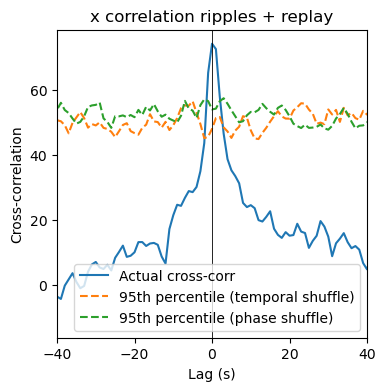

In [58]:
# Convert to arrays and average across animals
mean_x = np.mean(np.array(all_x_rip_rep), axis=0)
mean_y = np.mean(np.array(all_y_rip_rep), axis=0)
mean_y_shuf = np.mean(np.array(all_y_shuf_rip_rep), axis=0)
mean_y_shuf_2 = np.mean(np.array(all_y_shuf_2_rip_rep), axis=0)

plt.figure(figsize=(4,4))
plt.plot(mean_x, convolve_movmean(mean_y,3), label='Actual cross-corr')
plt.plot(mean_x, convolve_movmean(mean_y_shuf,3), linestyle='--', label='95th percentile (temporal shuffle)')
plt.plot(mean_x, convolve_movmean(mean_y_shuf_2,3), linestyle='--', label='95th percentile (phase shuffle)')
plt.axvline(0, color='k', linewidth=0.6)
plt.xlabel('Lag (s)')            # or 'Lag (ms)' if you multiply by 1000
plt.ylabel('Cross-correlation')
plt.legend()
plt.title('x correlation ripples + replay')
plt.xlim(-40,40)

(-40.0, 40.0)

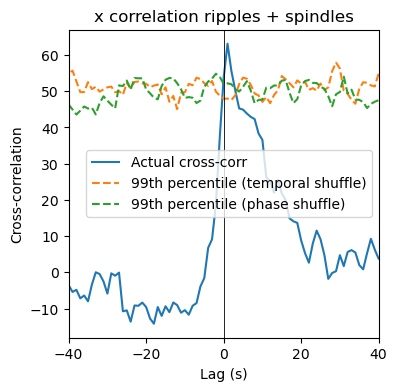

In [134]:
# Convert to arrays and average across animals
mean_x = np.mean(np.array(all_x_rip_spind), axis=0)
mean_y = np.mean(np.array(all_y_rip_spind), axis=0)
mean_y_shuf = np.mean(np.array(all_y_shuf_rip_spind), axis=0)
mean_y_shuf_2 = np.mean(np.array(all_y_shuf_2_rip_spind), axis=0)

plt.figure(figsize=(4,4))
plt.plot(mean_x, convolve_movmean(mean_y,3), label='Actual cross-corr')
plt.plot(mean_x, convolve_movmean(mean_y_shuf,3), linestyle='--', label='99th percentile (temporal shuffle)')
plt.plot(mean_x, convolve_movmean(mean_y_shuf_2,3), linestyle='--', label='99th percentile (phase shuffle)')
plt.axvline(0, color='k', linewidth=0.6)
plt.xlabel('Lag (s)')            # or 'Lag (ms)' if you multiply by 1000
plt.ylabel('Cross-correlation')
plt.legend()
plt.title('x correlation ripples + spindles')
plt.xlim(-40,40)

{'whiskers': [<matplotlib.lines.Line2D at 0x15aa5881510>,
 'caps': [<matplotlib.lines.Line2D at 0x15aa5881b10>,
 'boxes': [<matplotlib.patches.PathPatch at 0x15aa58810c0>],
 'medians': [<matplotlib.lines.Line2D at 0x15aa5882110>],
 'fliers': [<matplotlib.lines.Line2D at 0x15aa5882410>],
 'means': []}

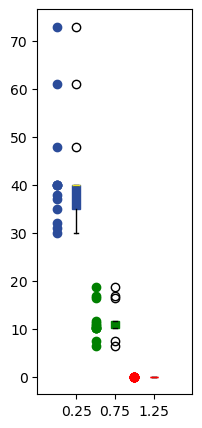

In [115]:
fig, ax = plt.subplots(figsize=(2, 5))

ax.plot(np.zeros(len(max_ripple_rpms)), max_ripple_rpms, 'o', color = '#2B4C9A')
ax.boxplot(max_ripple_rpms, positions=[0.25], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#2B4C9A', color='#2B4C9A'), medianprops=dict(color='#EAE324'))

ax.plot(np.ones(len(mean_ripple_rpms))*0.5, mean_ripple_rpms, 'o', color = 'green')
ax.boxplot(mean_ripple_rpms, positions=[0.75], widths=0.1, patch_artist=True, boxprops=dict(facecolor='green', color='green'), medianprops=dict(color='green'))

ax.plot(np.ones(len(min_ripple_rpms)), min_ripple_rpms, 'o', color = 'red')
ax.boxplot(min_ripple_rpms, positions=[1.25], widths=0.1, patch_artist=True, boxprops=dict(facecolor='red', color='red'), medianprops=dict(color='red'))


Text(0.5, 1.0, 'percentage of replay linked to SW-R')

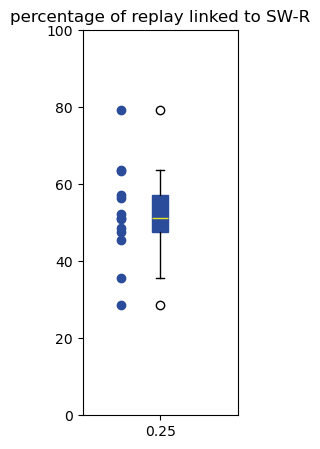

In [175]:
fig, ax = plt.subplots(figsize=(2, 5))

ax.plot(np.zeros(len(all_prop_replay_linked_to_SWR)), np.array(all_prop_replay_linked_to_SWR)*100, 'o', color = '#2B4C9A')
ax.boxplot(np.array(all_prop_replay_linked_to_SWR)*100, positions=[0.25], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#2B4C9A', color='#2B4C9A'), medianprops=dict(color='#EAE324'))
ax.set_ylim(0,100)
ax.set_title('percentage of replay linked to SW-R')

Text(0.5, 1.0, 'percentage of replay linked to SW-R')

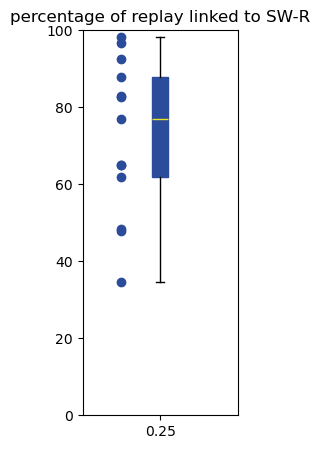

In [176]:
fig, ax = plt.subplots(figsize=(2, 5))

ax.plot(np.zeros(len(all_proportion_SWR_linked_to_replay)), np.array(all_proportion_SWR_linked_to_replay)*100, 'o', color = '#2B4C9A')
ax.boxplot(np.array(all_proportion_SWR_linked_to_replay)*100, positions=[0.25], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#2B4C9A', color='#2B4C9A'), medianprops=dict(color='#EAE324'))
ax.set_ylim(0,100)
ax.set_title('percentage of replay linked to SW-R')

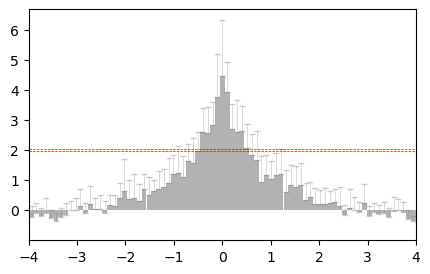

In [59]:
### linkage plot 

all_z_data= []
for i in range(len(all_min_lags_actual)):
    np.histogram(all_min_lags_actual[i], bins=all_linkage_bins[i])
    data, bins = np.histogram(all_min_lags_actual[i], bins=all_linkage_bins[i])
    normalised_data = zscore(data)
    all_z_data +=[normalised_data]

fig,ax,= plt.subplots(1, 1,figsize=(5, 3))

# Compute bin centers for bar plot
widths = np.diff(bins)

bin_centres = np.linspace(-10,10,len(bins)-1 )

# Error bar style
error_style = dict(ecolor='grey', elinewidth=0.5, capsize=2, alpha = 0.4)
ax.bar(bin_centres, np.mean(all_z_data,axis = 0), width=widths, yerr=[np.zeros_like(np.mean(all_z_data,axis = 0)),np.std(all_z_data,axis = 0)],align='center', alpha = 0.6, color = 'grey', error_kw=error_style)
ax.set_xlim(-4,4)


all_rand_ripples_z_data= []
for i in range(len(all_min_lags_rand_ripples)):
    np.histogram(all_min_lags_rand_ripples[i], bins=all_linkage_bins[i])
    data, bins = np.histogram(all_min_lags_rand_ripples[i], bins=all_linkage_bins[i])
    normalised_data = zscore(data)
    all_rand_ripples_z_data +=[normalised_data]
mean_all_rand_ripples_z_data_95 = np.percentile(np.mean(all_rand_ripples_z_data,axis = 0), 95)
ax.axhline(mean_all_rand_ripples_z_data_95, color='green', lw=0.5, ls='--', label = 'randomised ripples 95th percentile')

all_rand_replay_z_data= []
for i in range(len(all_min_lags_rand_replay)):
    np.histogram(all_min_lags_rand_replay[i], bins=all_linkage_bins[i])
    data, bins = np.histogram(all_min_lags_rand_replay[i], bins=all_linkage_bins[i])
    normalised_data = zscore(data)
    all_rand_replay_z_data +=[normalised_data]
mean_all_rand_replay_z_data_95 = np.percentile(np.mean(all_rand_replay_z_data,axis = 0), 95)
ax.axhline(mean_all_rand_replay_z_data_95, color='red', lw=0.5, ls='--', label = 'randomised replay 95th percentile')

array([56.50442478, 28.67132867, 48.766246  , 45.59585492, 57.17299578,
       50.91743119, 52.29173637, 51.27659574, 47.72727273, 79.37743191,
       63.63636364, 63.53637902, 35.57483731])

In [160]:
all_prop_replay_linked_to_SWR

[[0.5650442477876106],
 [0.2867132867132867],
 [0.48766245997362967],
 [0.45595854922279794],
 [0.5717299578059072],
 [0.5091743119266054],
 [0.5229173636667782],
 [0.5127659574468085],
 [0.4772727272727273],
 [0.7937743190661478],
 [0.6363636363636364],
 [0.6353637901861252],
 [0.3557483731019523]]

In [145]:
all_prop_replay_linked_to_SWR

[[array(0.56504425)],
 [array(0.28671329)],
 [array(0.48766246)],
 [array(0.45595855)],
 [array(0.57172996)],
 [array(0.50917431)],
 [array(0.52291736)],
 [array(0.51276596)],
 [array(0.47727273)],
 [array(0.79377432)],
 [array(0.63636364)],
 [array(0.63536379)],
 [array(0.35574837)]]

In [ ]:

all_proportion_SWR_linked_to_replay

In [ ]:
rates_per_minute

In [371]:
#### linkage analysis 
# replay count vs time lag to closest ripple
# percentage of relays that are linked to a ripple
# percentag of ripples linked to replay 

In [372]:
import random

def define_ripple_linkage(spindle_events,replay_times):
    spindle_linkage_distance = []
    for event in replay_times:
        current_shortest_dist = 999999
        for spin_mid in spindle_events:
            distance = abs(spin_mid - event)
            if distance < abs(current_shortest_dist):
                current_shortest_dist = (spin_mid - event)
        spindle_linkage_distance += [current_shortest_dist]
    return spindle_linkage_distance

def generate_filtered_floats(ranges, events, buffer=2.0, num_values=100, max_attempts=10000):
    """
    Generates random float values from specified ranges, excluding values that are
    within `buffer` distance of any value in `events`.

    Parameters:
        ranges (list of [start, end]): List of [start, end] intervals to sample from.
        events (list of float): Values to avoid within the buffer zone.
        buffer (float): Minimum distance from events.
        num_values (int): Number of float values to generate.
        max_attempts (int): Maximum number of attempts to find valid values.

    Returns:
        list of float: Filtered random float values.
    """
    def is_too_close(value, events, buffer):
        return any(abs(value - e) < buffer for e in events)

    valid_values = []
    attempts = 0

    while len(valid_values) < num_values and attempts < max_attempts:
        start, end = random.choice(ranges)
        val = random.uniform(start, end)
        if not is_too_close(val, events, buffer):
            valid_values.append(val)
        attempts += 1

    if len(valid_values) < num_values:
        print(f"Warning: Only found {len(valid_values)} valid values after {attempts} attempts.")
    
    return valid_values


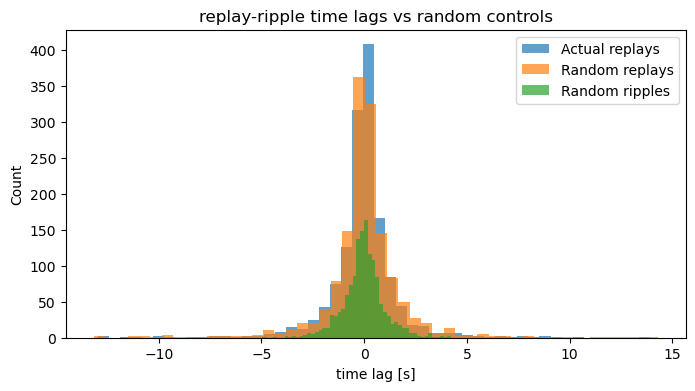

In [397]:
relevant_ripples = []
for span in chunk_spans:
    relevant_ripples += list(ripple_starts[(ripple_starts > span[0]) * (ripple_starts < span[-1])])
relevant_ripples= np.array(relevant_ripples)
replay_times = np.array(replay_mids)

# --- 1️⃣ Compute signed nearest-ripple lag for each replay
# Difference matrix (ripple - replay)
diffs = relevant_ripples[None, :] - replay_times[:, None]

# For each replay, find ripple with minimal |difference| but keep sign
nearest_idx = np.argmin(np.abs(diffs), axis=1)
min_lags_actual = diffs[np.arange(len(replay_times)), nearest_idx]

# draw random events chunk wise 
random_ripples = []
random_replays = []
for span in chunk_spans:
    # # random ripples
    total_ripples_chunk = len(list(ripple_starts[(ripple_starts > span[0]) * (ripple_starts < span[-1])]))
    random_ripples += list(np.random.uniform(span[0], span[-1], total_ripples_chunk))
    # random replay 
    total_replay_chunk = len(list(replay_times[(replay_times > span[0]) * (replay_times < span[-1])]))
    random_replays += list(np.random.uniform(span[0], span[-1], total_replay_chunk))

random_ripples = np.array(random_ripples)
random_replays = np.array(random_replays)

#rand replay 
diffs = relevant_ripples[None, :] - random_replays[:, None]
nearest_idx = np.argmin(np.abs(diffs), axis=1)
min_lags_rand_replay = diffs[np.arange(len(random_replays)), nearest_idx]

#rand ripples 
diffs = random_ripples[None, :] - replay_times[:, None]
nearest_idx = np.argmin(np.abs(diffs), axis=1)
min_lags_rand_ripples = diffs[np.arange(len(replay_times)), nearest_idx]

# --- 3️⃣ Plot signed lag distributions
plt.figure(figsize=(8, 4))
plt.hist(min_lags_actual, bins=50, alpha=0.7, label="Actual replays")
plt.hist(min_lags_rand_replay, bins=50, alpha=0.7, label="Random replays")
plt.hist(min_lags_rand_ripples, bins=50, alpha=0.7, label="Random ripples")
plt.xlabel("time lag [s]")
plt.ylabel("Count")
plt.legend()
plt.title("replay-ripple time lags vs random controls")
plt.show()

In [411]:
relevant_ripples


array([11500.15605857, 11501.09485857, 11501.24605857, ...,
       14989.34285857, 14997.83605857, 14998.09645857], shape=(1811,))

In [406]:
ripple_starts

0        8094.520859
1        8096.581259
2        8098.708859
3        8098.927259
4        8105.705259
            ...     
3505    15441.983259
3506    15443.172459
3507    15445.637659
3508    15446.276059
3509    15448.284059
Name: start_time, Length: 3510, dtype: float64

In [410]:
len(min_lags_actual)

1422

In [402]:
len((abs(min_lags_actual) < 1.5) * 1)/ len(min_lags_actual)

1.0

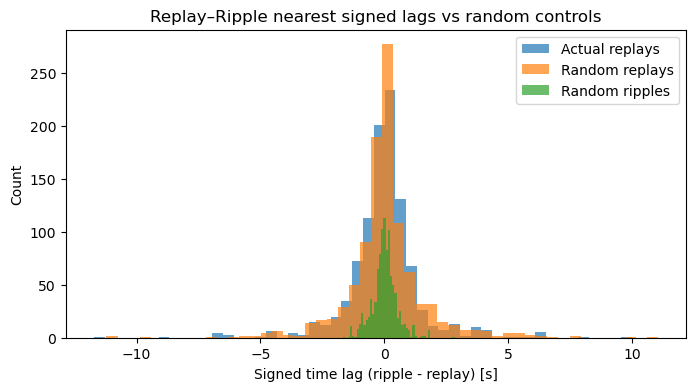

In [355]:
import numpy as np
import matplotlib.pyplot as plt

# Example inputs
# replay_fs_times = np.array([...])
# ripple_starts = np.array([...])

replay_fs_times = np.array(replay_fs_times)
ripple_starts = np.array(ripple_starts)

# Define the valid replay period
start_time = np.min(replay_fs_times)
end_time = np.max(replay_fs_times)

# --- 1️⃣ Compute signed nearest-ripple lag for each replay
# Difference matrix (ripple - replay)
diffs = ripple_starts[None, :] - replay_fs_times[:, None]

# For each replay, find ripple with minimal |difference| but keep sign
nearest_idx = np.argmin(np.abs(diffs), axis=1)
min_lags_actual = diffs[np.arange(len(replay_fs_times)), nearest_idx]

# --- 2️⃣ Randomized controls (within replay window)
num_replays = len(replay_fs_times)
num_ripples = len(ripple_starts)

random_replays = np.random.uniform(start_time, end_time, num_replays)
random_ripples = np.random.uniform(start_time, end_time, num_ripples)

# Random replays
diffs_rand_replay = ripple_starts[None, :] - random_replays[:, None]
nearest_idx_rand_replay = np.argmin(np.abs(diffs_rand_replay), axis=1)
min_lags_rand_replay = diffs_rand_replay[np.arange(num_replays), nearest_idx_rand_replay]

# Random ripples
diffs_rand_ripple = random_ripples[None, :] - replay_fs_times[:, None]
nearest_idx_rand_ripple = np.argmin(np.abs(diffs_rand_ripple), axis=1)
min_lags_rand_ripple = diffs_rand_ripple[np.arange(num_replays), nearest_idx_rand_ripple]

# --- 3️⃣ Plot signed lag distributions
plt.figure(figsize=(8, 4))
plt.hist(min_lags_actual, bins=50, alpha=0.7, label="Actual replays")
plt.hist(min_lags_rand_replay, bins=50, alpha=0.7, label="Random replays")
plt.hist(min_lags_rand_ripple, bins=50, alpha=0.7, label="Random ripples")
plt.xlabel("Signed time lag (ripple - replay) [s]")
plt.ylabel("Count")
plt.legend()
plt.title("Replay–Ripple nearest signed lags vs random controls")
plt.show()


In [ ]:
# percentage of relays that are linked to a ripple

# percentag of ripples linked to replay 


##### run across all animals ------- 

In [ ]:
# example ripple

# ripples per minute
# ripples and replay correlation
# ripples + spindles correlation 

# replay count vs time lag to closest ripple
# percentage of relays that are linked to a ripple
# percentag of ripples linked to replay 

# ripple power/length and replay/spindles

# event triggers ripple average?
# ripple linked features vs unlinked. 



# even if they dont correlate are ripples more likley druing replay epochs

In [100]:
os.listdir(dat_path)

['quick_view_output',
 'seq006_1_10_run_0808025_0701',
 'seq006_1_11_run_2905025_1007',
 'seq006_1_1_run_0907025_1800',
 'seq006_1_3_run_0908025_1017',
 'seq006_1_4_run_2805025_0013',
 'seq006_1_5_run_2505025_0247',
 'seq006_1_6_run_2905025_0946',
 'seq006_1_8_run_0908025_0601',
 'seq006_1_9_run_0908025_0756',
 'seq007_1_1_run_2605025_2356',
 'seq007_1_2_run_2905025_0509',
 'seq007_1_3_run_2905025_0930',
 'seq007_1_4_run_2405025_0900',
 'seq008_1_3_run_2005025_1712',
 'seq120_1_1_run_1010025_1548',
 'seq120_1_2_run_1010025_0814',
 'seq120_1_3_run_0810025_0313',
 'seq120_1_4_run_0710025_1505',
 'seq120_1_5_run_0810025_1041',
 'seq120_1_6_run_0810025_1718',
 'seq120_1_7_run_0810025_1634',
 'seq120_1_8_run_1010025_0355']

In [105]:
file = os.listdir(dat_path)[5]

'seq006_1_4'

In [467]:
mouse = current_mouse
dat_path = replay_path

print('---------------------')
print('searching for replay data')

pp_path = 'SKIP'
for file in os.listdir(dat_path):
    if mouse == file.split('_run')[0]:
        print(f'file found: \033[1m{file}\033[0m')
        pp_path = os.path.join(dat_path,file)

if pp_path == 'SKIP':
    print('skipped')
    # return None,'SKIP'
replay_data_path = pp_path + r'\_final_analysis_output\\'

params_file = pp_path + r'\trainingData\\' + 'params_' + mouse + '.json'
with open(params_file, 'r') as file:
    params = json.load(file)
time_spans = params['time_span']

replay_events_df = pd.DataFrame({})
start_offset = []
for file in os.listdir(replay_data_path):
    if 'chunk' in file:
        print(file)

        chunk_number = int(file.split('_')[0][-1])

        start_offs = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
        start_offset +=[start_offs]


        print(replay_data_path)

        df_load = pd.read_csv(replay_data_path + file + r'\filtered_replay_clusters_df.csv',index_col=0)
        df_load['chunk'] = [chunk_number]*len(df_load)
        
        df_load['chunk_time'] = [time_spans[chunk_number-1]]*len(df_load)
        fs_times_ephys_time = (df_load.first_spike_time.values - start_offs)
        df_load['first_spike_ephys_time'] = fs_times_ephys_time
        df_load["replay_abs_time"] = df_load['chunk_time'].values[0][0] + df_load["first_spike_ephys_time"] + df_load["event_length"]/2
        replay_events_df = pd.concat((replay_events_df,df_load),axis =0)
        replay_events_df.reset_index(drop = True)

        print (f"\033[1mSuccess!\033[0m Loaded replay data files for mouse: {mouse}.")
        print('---------------------')

---------------------
searching for replay data
file found: seq006_1_1_run_0907025_1800
chunk1_11300to13600
Z:\projects\sequence_squad\ppseq_finalised_publication_data\dual_str_hpc\striatum\postsleep\\seq006_1_1_run_0907025_1800\_final_analysis_output\\
Success! Loaded replay data files for mouse: seq006_1_1.
---------------------


In [115]:
os.listdir(replay_data_path)

['filtering_curve.png', 'log_l_curve.png', 'state_rates_df.csv']